# Assignment 1

In this notebook we will be exploring 5 different supervised learning algorithms on 2 datasets. The 5 algorithms explored are 1. SVM, 2. KNN, 3. Decision Trees, 4. Boosted Trees and 5. ANN. The datasets are classification problems and can be openly found on the internet. The 2 datasets used are 1. Heart Disease Dataset and 2. Credit Card Default Dataset. 

These datasets present different challenges and the goal of this assignment is to gain a better understand of the algorithms and the processing pipeline.

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
# Import sklearn 
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV,RandomizedSearchCV,StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import balanced_accuracy_score, f1_score, accuracy_score,classification_report,confusion_matrix, ConfusionMatrixDisplay
# Plotting tools
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# Misc tools
import time
import random

In [2]:
# Make the figures bigger
plt.rcParams.update({'font.size': 20})

## Load Data

In [3]:
# Import the first dataset: Heart Disease Dataset
heart_df = pd.read_csv('./heart_2.csv')
# Import second dataset : CC default Dataset
bank_df = pd.read_csv("./credit_card.csv")
bank_df = bank_df.drop(columns=['ID'])

In [4]:
# Get info about heart dataset
heart_df.describe()

age          sex           cp     trestbps        chol  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.00000   
mean     54.434146     0.695610     0.942439   131.611707   246.00000   
std       9.072290     0.460373     1.029641    17.516718    51.59251   
min      29.000000     0.000000     0.000000    94.000000   126.00000   
25%      48.000000     0.000000     0.000000   120.000000   211.00000   
50%      56.000000     1.000000     1.000000   130.000000   240.00000   
75%      61.000000     1.000000     2.000000   140.000000   275.00000   
max      77.000000     1.000000     3.000000   200.000000   564.00000   

               fbs      restecg      thalach        exang      oldpeak  \
count  1025.000000  1025.000000  1025.000000  1025.000000  1025.000000   
mean      0.149268     0.529756   149.114146     0.336585     1.071512   
std       0.356527     0.527878    23.005724     0.472772     1.175053   
min       0.000000     0.000000    71.000000     0.000000     0.000000   
25%       0.000000     0.000000   132.000000     0.000000     0.000000   
50%       0.000000     1.000000   152.000000     0.000000     0.800000   
75%       0.000000     1.000000   166.000000     1.000000     1.800000   
max       1.000000     2.000000   202.000000     1.000000     6.200000   

             slope           ca         thal       target  
count  1025.000000  1025.000000  1025.000000  1025.000000  
mean      1.385366     0.754146     2.323902     0.513171  
std       0.617755     1.030798     0.620660     0.500070  
min       0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     2.000000     0.000000  
50%       1.000000     0.000000     2.000000     1.000000  
75%       2.000000     1.000000     3.000000     1.000000  
max       2.000000     4.000000     3.000000     1.000000

## Preprocessing

In [5]:
# Check for missing info heart
if heart_df.isnull().values.any():
    print('Missing Heart Data!')
else:
    print('No missing Heart data!')
    
# Check for missing info CC
if bank_df.isnull().values.any():
    print('Missing CC Data!')
else:
    print('No missing CC data!')

No missing Heart data!
No missing CC data!


In [6]:
# Split the data into independent and dependent variables
heart_X = heart_df.drop(columns =['target'])
heart_y = heart_df['target']

bank_X = bank_df.drop(columns=['default'])
bank_y = bank_df[['default']]

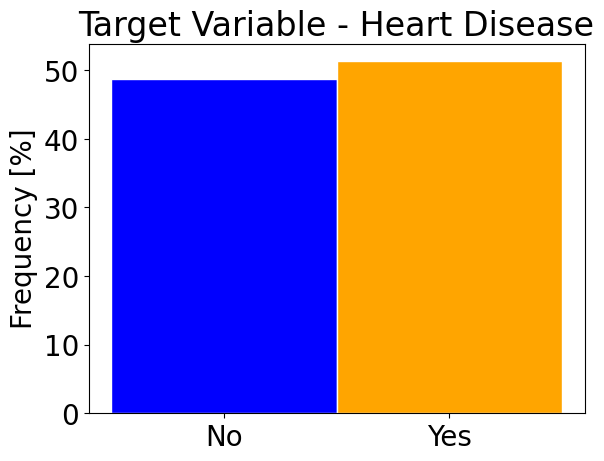

In [7]:
# Get target variable data
heart_result = heart_y.values
colors = ['blue', 'orange']
labels = ['No','Yes']
fig, ax = plt.subplots(facecolor='w')
cnts, values, bars = ax.hist(heart_result, edgecolor='w', bins=np.arange(3)-0.5,weights = np.ones_like(heart_y.index)*100 / len(heart_y.index))
ax.set_xticks([0,1], labels)
plt.title('Target Variable - Heart Disease')
plt.ylabel('Frequency [%]')

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(colors[i % len(colors)])

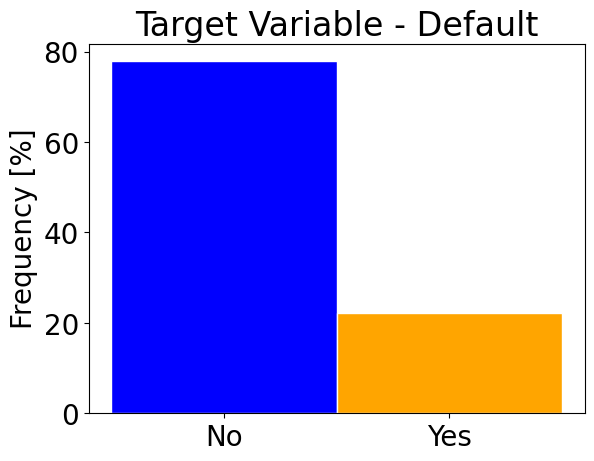

In [8]:
bank_result = bank_df['default'].values
colors = ['blue', 'orange']
labels = ['No','Yes']
fig, ax = plt.subplots(facecolor='w')
cnts, values, bars = ax.hist(bank_result, edgecolor='w', bins=np.arange(3)-0.5,weights = np.ones_like(bank_df.index)*100 / len(bank_df.index))
ax.set_xticks([0,1], labels)
plt.title('Target Variable - Default')
plt.ylabel('Frequency [%]')

for i, (cnt, value, bar) in enumerate(zip(cnts, values, bars)):
    bar.set_facecolor(colors[i % len(colors)])

Note the skewness for the credit card target variable dataset. 

In [9]:
# Next we will be splitting the data into the training and test set
# 70:30 for heart and 2:1 for CC
X_train_heart, X_test_heart, y_train_heart, y_test_heart = train_test_split(heart_X, heart_y,
                                                    test_size = 0.3, random_state = 42, stratify = heart_y
                                                   )

X_train_bank, X_test_bank, y_train_bank, y_test_bank = train_test_split(bank_X, bank_y,
                                                    train_size = (1/3), random_state = 42, stratify = bank_df['default']
                                                   )

## SVM Classifier

In [135]:
def svm_baseline_pipeline(X_train,y_train,cv, name):
    
    #Define pipeline as we need to perform scaling
    pipeline_heart_poly_base = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('SVC',SVC(
        random_state = 42,
        kernel = 'poly',
        ))
    ])

    sizes, training_scores, val_scores, fit_times, score_times = learning_curve(
        pipeline_heart_poly_base,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )

    #Training scores
    train_mean_poly = np.mean(training_scores, axis=1)
    #Validation scores
    val_mean_poly = np.mean(val_scores, axis=1)
    #Fit time
    fit_times_mean_poly = np.mean(fit_times, axis=1)
    #Score time
    score_times_mean_poly = np.mean(score_times, axis=1)

##############################################################
    pipeline_heart_base = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('SVC',SVC(
        random_state = 42,
        ))
    ])

    sizes, training_scores, val_scores, fit_times, score_times = learning_curve(
        pipeline_heart_base,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    
    #Training scores
    train_mean_rbf = np.mean(training_scores, axis=1)
    #Validation scores
    val_mean_rbf = np.mean(val_scores, axis=1)
    #Fit time
    fit_times_mean_rbf = np.mean(fit_times, axis=1)
    #Score time
    score_times_mean_rbf = np.mean(score_times, axis=1)

    #Plot the curves
    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean_rbf, '--', color="b",  label="Training score RBF")
    plt.plot(sizes, val_mean_rbf, color="r", label="Cross-validation score RBF")
    # Use green and orange for the alternative set
    plt.plot(sizes, train_mean_poly, '--', color="g",  label="Training score Poly")
    plt.plot(sizes, val_mean_poly,color="orange", label="Cross-validation score Poly")

    # Drawing plot
    plt.title("Learning curve for baseline SVC Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()

    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, fit_times_mean_rbf, '--', color="b",  label="Fit Time RBF")
    plt.plot(sizes, score_times_mean_rbf, color="r", label="Score Time RBF")
    # Use green and orange for the alternative set
    plt.plot(sizes, fit_times_mean_poly, '--', color="g",  label="Fit Time Poly")
    plt.plot(sizes, score_times_mean_poly, color="orange", label="Score Time Poly")

    # Drawing plot
    plt.title("Time Complexity for baseline SVC Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Time Taken [s]"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    print('')
    return train_mean_rbf, val_mean_rbf,fit_times_mean_rbf,score_times_mean_rbf,sizes

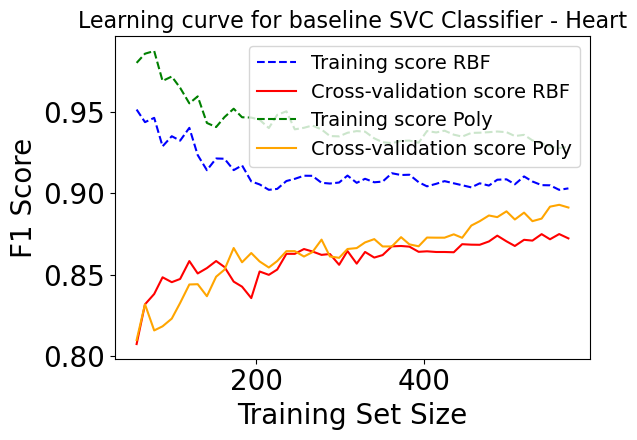

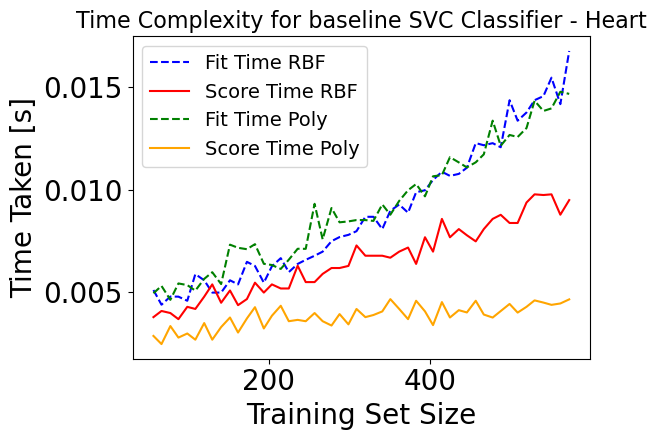


Wall time: 3.25 s


In [136]:
%%time
train_svc_heart_base, val_svc_heart_base,fit_svc_heart_base,score_svc_heart_base,sizes_heart = svm_baseline_pipeline(X_train_heart,y_train_heart,5, 'Heart')

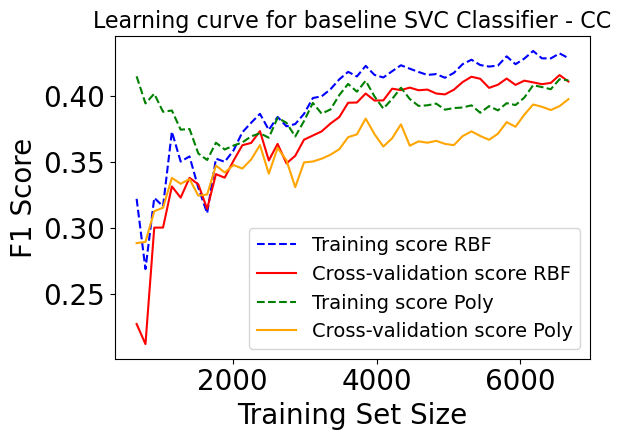

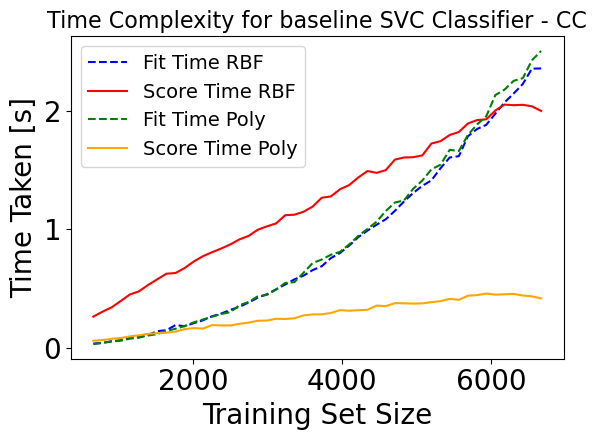


Wall time: 1min 42s


In [137]:
%%time
train_mean_rbf_bank_base, val_mean_rbf_bank_base,fit_times_mean_bank_base,score_times_mean_bank_base,sizes_bank = svm_baseline_pipeline(X_train_bank,y_train_bank,3, 'CC')

In [12]:
# Get scores
def scoring_matrix(pipeline, X_train,y_train, X_test, y_test, name,algo):
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    elapsed_time = (time.time() - start_time)
    print('Fitting Time: '+str(elapsed_time))
    start_time = time.time()
    y_pred = pipeline.predict(X_test)
    elapsed_time = (time.time() - start_time)
    print('Scoring Time: '+str(elapsed_time))
    pred_score = f1_score(y_pred, y_test)
    print('F1 Score - '+name+' - '+algo+': ' +str(pred_score))
    target_names = ['No', 'Yes']
    print(classification_report(y_test, y_pred,target_names=target_names))

    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['No','Yes'],
                                 )
    disp.plot()
    disp.im_.colorbar.remove()
    plt.title(algo + ' Confusion Matrix - '+ name)
    plt.show()

Fitting Time: 0.01294088363647461
Scoring Time: 0.00897216796875
F1 Score - Heart - SVC: 0.889589905362776
              precision    recall  f1-score   support

          No       0.89      0.88      0.88       150
         Yes       0.89      0.89      0.89       158

    accuracy                           0.89       308
   macro avg       0.89      0.89      0.89       308
weighted avg       0.89      0.89      0.89       308



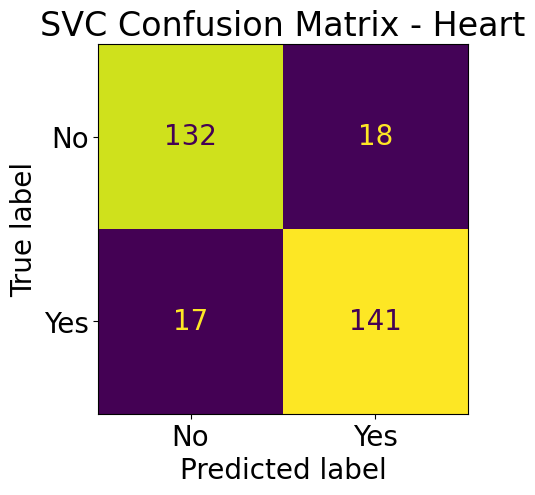

In [13]:
pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('SVC',SVC(
    random_state = 42,
    ))
])

scoring_matrix(pipeline,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart', 'SVC')
#scoring_matrix(pipeline,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC', 'SVC')

## Hyperparameter Tuning

In [14]:
def hyperSVC_C(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = [0.0001,0.001,0.01,0.1,1,2,5]
    for i in klist:
        clf = Pipeline([
        ('Scale',MinMaxScaler()),
        ('SVC',SVC(
            random_state = 42,
            C = i
                  ))
        ])
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train')    
    plt.plot(klist, f1_test, 'o-', color='r', label='Test')
    plt.ylabel('F1 Score')
    plt.xlabel('C values')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    
def hyperSVC_kernel(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf','sigmoid']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3,4,5,6,7,8]:
                    clf = Pipeline([
                        ('Scale',MinMaxScaler()),
                        ('SVC',SVC(
                            random_state = 42,
                            kernel = i,
                            degree = j
                        ))
                    ])
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = Pipeline([
                    ('Scale',MinMaxScaler()),
                    ('SVC',SVC(
                        random_state = 42,
                        kernel = i,
                        ))
                    ])
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['lin','p2','p3','p4','p5','p6','p7','p8','rbf','sig']
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()

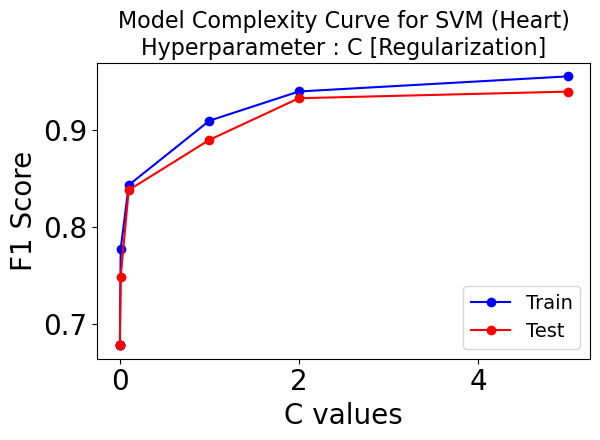

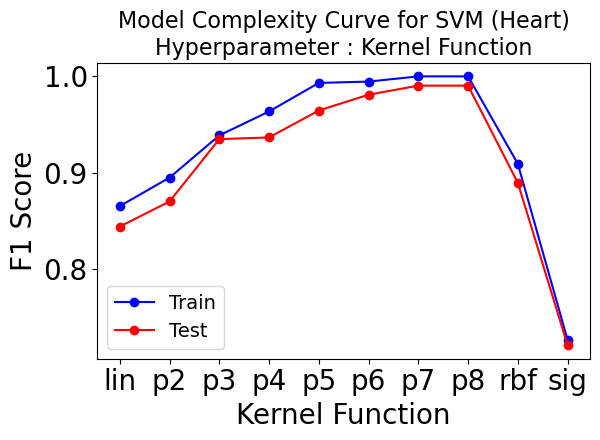

Wall time: 827 ms


In [15]:
%%time
hyperSVC_C(X_train_heart, y_train_heart,X_test_heart,y_test_heart, "Model Complexity Curve for SVM (Heart)\nHyperparameter : C [Regularization]")
hyperSVC_kernel(X_train_heart, y_train_heart,X_test_heart,y_test_heart, "Model Complexity Curve for SVM (Heart)\nHyperparameter : Kernel Function")

In [ ]:
hyperSVC_C(X_train_bank, y_train_bank,X_test_bank,y_test_bank, "Model Complexity Curve for SVM (CC)\nHyperparameter : C [Regularization]")
hyperSVC_kernel(X_train_bank, y_train_bank,X_test_bank,y_test_bank, "Model Complexity Curve for SVM (CC)\nHyperparameter : Kernel Function")

In [138]:
%%time
# Hyperparameter Tuning
def hpo(pipeline,X_train,X_test,y_train,y_test, params, cv, grid,n_iter):
    if grid == 1:
        cv_opt = GridSearchCV(pipeline,n_jobs=-1,param_grid=params,verbose=2,cv=cv,scoring='f1')
    else:
        cv_opt = RandomizedSearchCV(pipeline,n_jobs=-1,param_distributions=params,
                                    verbose=2,cv=cv,scoring='f1', n_iter =n_iter, random_state =42)
    cv_opt.fit(X_train, y_train)
    # Save the hyperparameter results into a dataframe
    HPO_Table = pd.DataFrame(cv_opt.cv_results_)
    # Train the model using best estimator and then fit onto the test data
    cv_opt.best_estimator_.fit(X_train, y_train)
    y_pred = cv_opt.best_estimator_.predict(X_test)
    pred_score_opt = f1_score(y_test, y_pred)
    print(cv_opt.best_params_)
    print('F1 Score Opt: '+ str(pred_score_opt))
    return cv_opt, HPO_Table

def plot_opt_vs_baseline_curves(cv_opt,X_train,X_test,y_train,y_test,cv,train_mean,val_mean,name,algo):
    sizes, training_scores_opt, val_scores_opt, fit_times, score_times = learning_curve(
        cv_opt.best_estimator_,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )

    # Plot
    # Score
    train_mean_opt = np.mean(training_scores_opt, axis=1)
    val_mean_opt = np.mean(val_scores_opt, axis=1)
    # Time
    fit_mean_opt = np.mean(fit_times, axis=1)
    score_mean_opt = np.mean(score_times, axis=1)

    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean_opt, '--', color="b",  label="Training score Opt")
    plt.plot(sizes, val_mean_opt, color="r", label="CV score Opt")
    plt.plot(sizes, train_mean, '--', color="g",  label="Training score Baseline")
    plt.plot(sizes, val_mean, color="orange", label="CV score Baseline")

    # Drawing plot
    plt.title("Learning curve for Optimized "+algo+" Classifier - "+ name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    return train_mean_opt,val_mean_opt,fit_mean_opt,score_mean_opt

Wall time: 0 ns


In [17]:
%%time
params_svc= {
    'SVC__C':[0.01,0.1,0.2,0.5,1,2,5],
    'SVC__gamma':["scale", "auto", 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0],
    'SVC__kernel':["linear", "poly", "rbf", "sigmoid"],
    'SVC__degree':[2,3,4,5,6,7,8]
}

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('SVC',SVC(
    random_state = 42,
    ))
])

cv_opt_heart, HPO_Table_heart = hpo(pipeline,X_train_heart,X_test_heart,y_train_heart,y_test_heart, params_svc, 5, 1,100)

Fitting 5 folds for each of 2352 candidates, totalling 11760 fits
{'SVC__C': 0.01, 'SVC__degree': 6, 'SVC__gamma': 1.4, 'SVC__kernel': 'poly'}
F1 Score Opt: 0.9904153354632589
Wall time: 48.1 s


In [ ]:
%%time

params_svc= {
    'SVC__C':[0.01,0.1,0.2,0.5,1,2,5],
    'SVC__gamma':["scale", "auto", 0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8,2.0],
    'SVC__kernel':["linear", "poly", "rbf", "sigmoid"],
    'SVC__degree':[2,3,4,5,6,7,8]
}

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('SVC',SVC(
    random_state = 42,
    ))
])

cv_opt_bank, HPO_Table_bank = hpo(pipeline,X_train_bank,X_test_bank,y_train_bank,y_test_bank, params_svc, 3, 0,100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


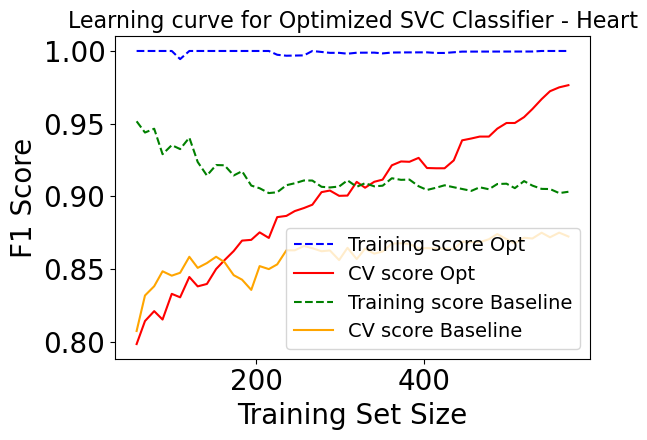

In [139]:
train_opt_svc_heart,val_opt_svc_heart,fit_opt_svc_heart,score_opt_svc_heart = plot_opt_vs_baseline_curves(cv_opt_heart,X_train_heart,X_test_heart,y_train_heart,y_test_heart,5,train_svc_heart_base, val_svc_heart_base, 'Heart', 'SVC')

In [161]:
# # From previous exp
# cv_opt_bank = Pipeline([   
#     ('Scale',MinMaxScaler()), 
#     ('SVC',SVC(
#     random_state = 42,
#         C=2,
#         gamma =2,
#         kernel ='poly'
#     ))
# ])
# cv_opt_bank.fit(X_train_bank, y_train_bank)

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('Scale', MinMaxScaler()),
                ('SVC', SVC(C=2, gamma=2, kernel='poly', random_state=42))])

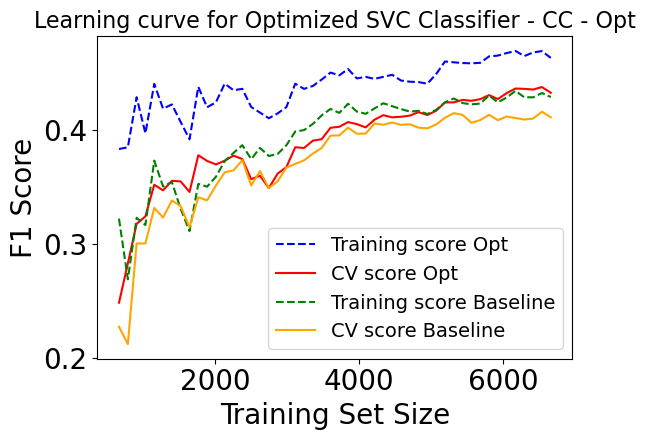

In [170]:
train_opt_svc_bank,val_opt_svc_bank,fit_opt_svc_bank,score_opt_svc_bank = plot_opt_vs_baseline_curves(cv_opt_bank,X_train_bank,X_test_bank,y_train_bank,y_test_bank,3,train_mean_rbf_bank_base, val_mean_rbf_bank_base, 'CC - Opt', 'SVC')


Fitting Time: 0.014951944351196289
Scoring Time: 0.0019936561584472656
F1 Score - Heart - SVC: 0.9904153354632589
              precision    recall  f1-score   support

          No       0.98      1.00      0.99       150
         Yes       1.00      0.98      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



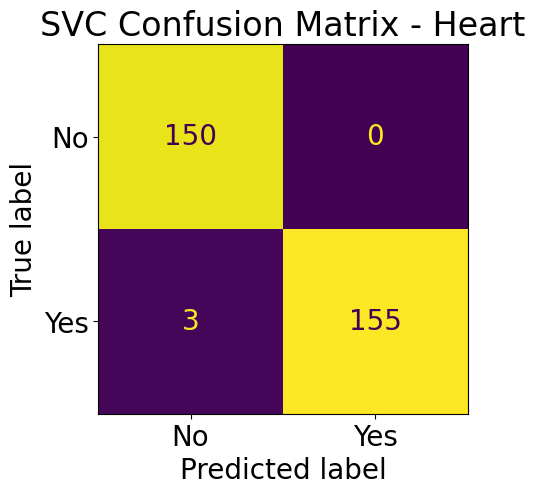

In [21]:
scoring_matrix(cv_opt_heart.best_estimator_,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart - Opt', 'SVC')

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Time: 2.486659288406372
Scoring Time: 7.169416666030884
F1 Score - CC - Opt - SVC: 0.45021906632421815
              precision    recall  f1-score   support

          No       0.84      0.95      0.89     15576
         Yes       0.68      0.34      0.45      4424

    accuracy                           0.82     20000
   macro avg       0.76      0.65      0.67     20000
weighted avg       0.80      0.82      0.79     20000



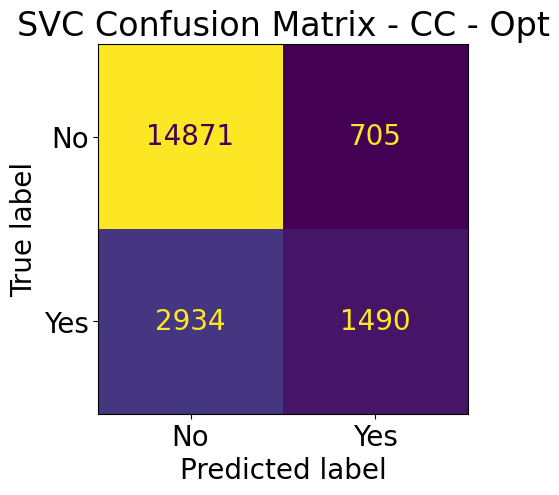

In [172]:
scoring_matrix(cv_opt_bank.best_estimator_,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC - Opt', 'SVC')

## KNN

In [24]:
def knn_baseline_pipeline(X_train,y_train,cv, name):
    
    #Define pipeline as we need to perform scaling
    pipeline = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('KNN',KNeighborsClassifier())
    ])

    sizes, training_scores, val_scores, fit_times, score_times = learning_curve(
        pipeline,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )

    #Training scores
    train_mean = np.mean(training_scores, axis=1)
    #Validation scores
    val_mean = np.mean(val_scores, axis=1)
    #Fit time
    fit_times_mean = np.mean(fit_times, axis=1)
    #Score time
    score_times_mean = np.mean(score_times, axis=1)

    #Plot the curves
    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean, '--', color="b",  label="Training score")
    plt.plot(sizes, val_mean, color="r", label="CV score")

    # Drawing plot
    plt.title("Learning curve for baseline KNN Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()

    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, fit_times_mean, '--', color="b",  label="Fit Time")
    plt.plot(sizes, score_times_mean, color="r", label="Score Time")

    # Drawing plot
    plt.title("Time Complexity for baseline KNN Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Time Taken [s]"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    print('')
    return train_mean, val_mean, fit_times_mean, score_times_mean

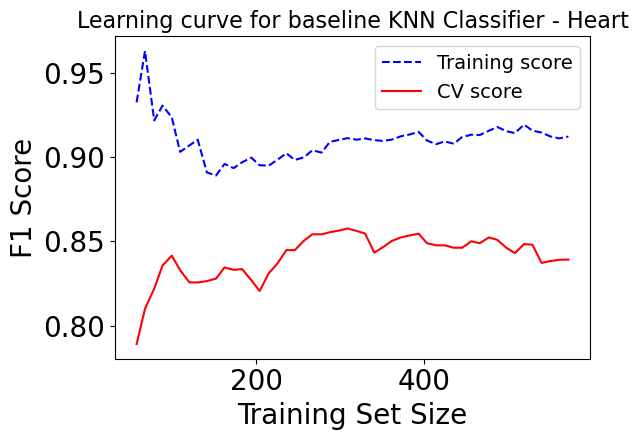

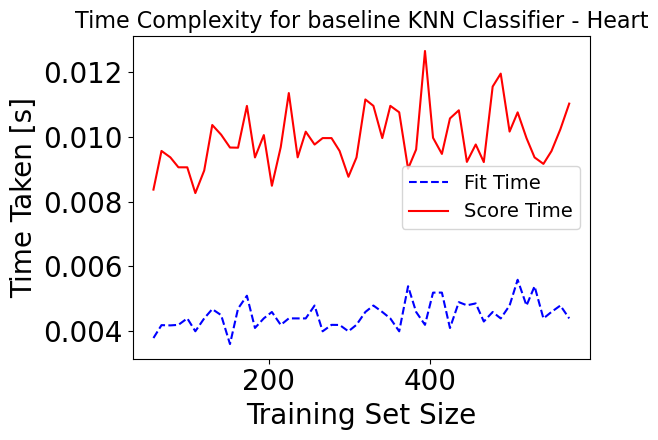


Wall time: 1.26 s


In [25]:
%%time
train_knn_heart_base, val_knn_heart_base, fit_knn_heart_base, score_knn_heart_base = knn_baseline_pipeline(X_train_heart,y_train_heart,5, 'Heart')

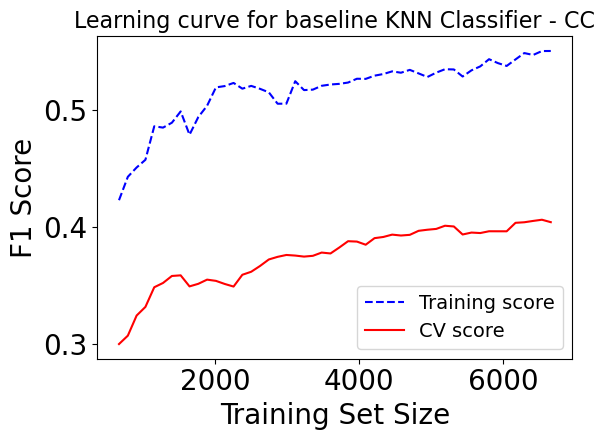

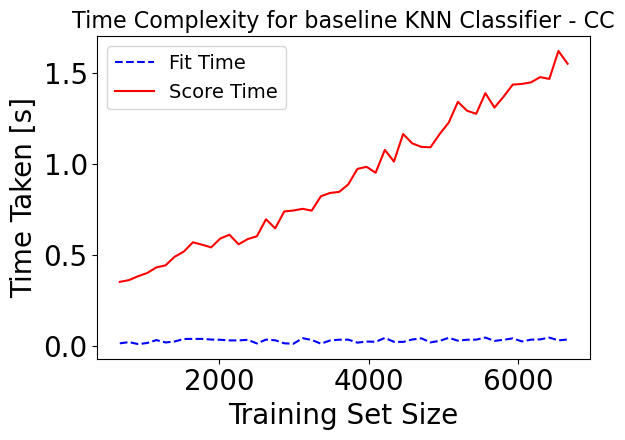


Wall time: 40.6 s


In [27]:
%%time
train_knn_bank_base, val_knn_bank_base, fit_knn_bank_base, score_knn_bank_base = knn_baseline_pipeline(X_train_bank,y_train_bank,3, 'CC')

Fitting Time: 0.004983186721801758
Scoring Time: 0.009965658187866211
F1 Score - Heart - KNN: 0.8333333333333334
              precision    recall  f1-score   support

          No       0.82      0.84      0.83       150
         Yes       0.84      0.82      0.83       158

    accuracy                           0.83       308
   macro avg       0.83      0.83      0.83       308
weighted avg       0.83      0.83      0.83       308



C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


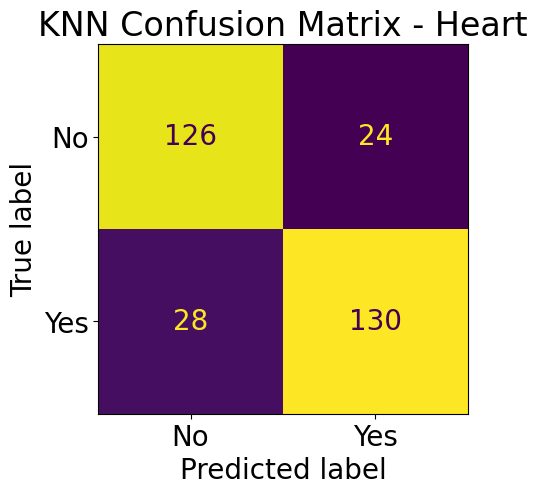

Fitting Time: 0.006299257278442383


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Scoring Time: 3.940384864807129
F1 Score - CC - KNN: 0.3937257159303498
              precision    recall  f1-score   support

          No       0.83      0.93      0.87     15576
         Yes       0.54      0.31      0.39      4424

    accuracy                           0.79     20000
   macro avg       0.68      0.62      0.63     20000
weighted avg       0.76      0.79      0.77     20000



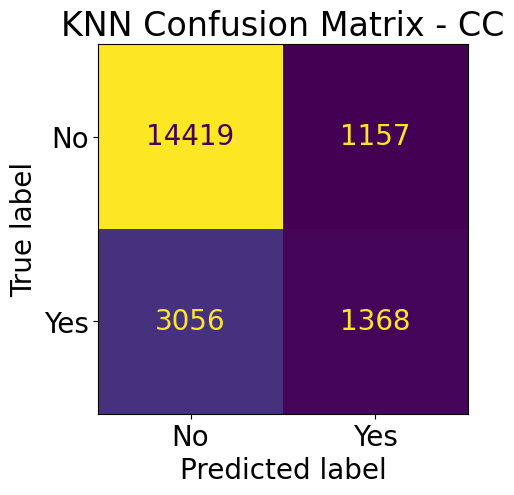

In [28]:
pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('KNN',KNeighborsClassifier())
])

scoring_matrix(pipeline,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart', 'KNN')
scoring_matrix(pipeline,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC', 'KNN')

## Hyperparameter Tuning

In [29]:
def hyperKNN_n(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,50,25).astype('int')
    for i in klist:
        clf = Pipeline([   
            ('Scale',MinMaxScaler()), 
            ('KNN',KNeighborsClassifier(n_neighbors=i,n_jobs=-1))
        ])
        
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(klist, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('# Neighbors')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
def hyperKNN_p(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = [1,2,3,4,5,6,7,8,9,10]
    for i in klist:
        clf = Pipeline([   
            ('Scale',MinMaxScaler()), 
            ('KNN',KNeighborsClassifier(p=i,n_jobs=-1))
        ])
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Train')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Test')
    plt.ylabel('F1 Score')
    plt.xlabel('Power Parameter')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

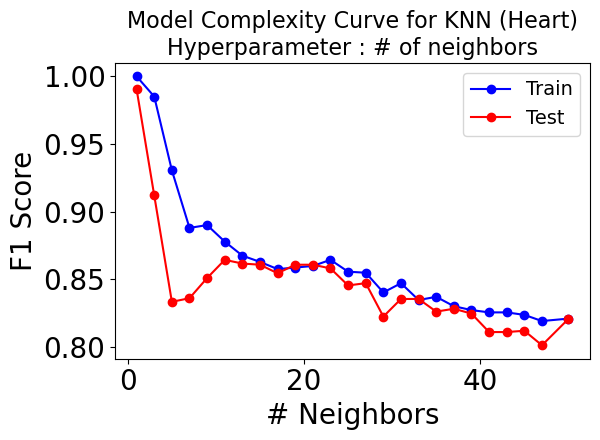

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


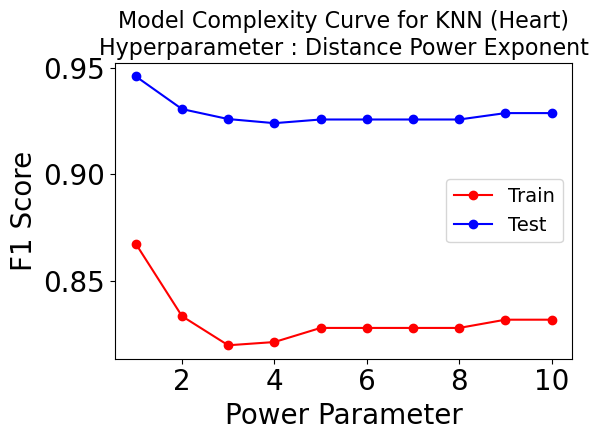

In [30]:
hyperKNN_n(X_train_heart, y_train_heart,X_test_heart,y_test_heart, "Model Complexity Curve for KNN (Heart)\nHyperparameter : # of neighbors")
hyperKNN_p(X_train_heart, y_train_heart,X_test_heart,y_test_heart, "Model Complexity Curve for KNN (Heart)\nHyperparameter : Distance Power Exponent")

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

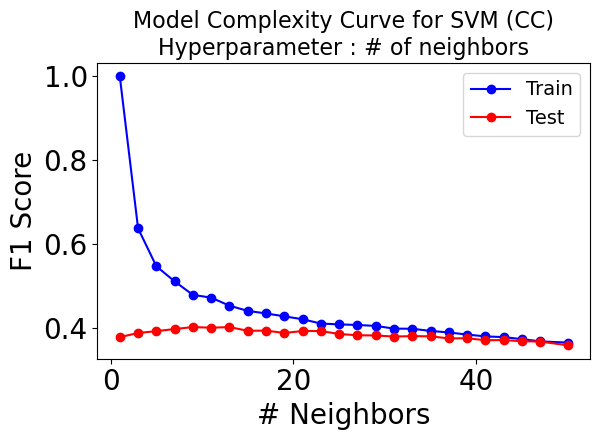

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `kee

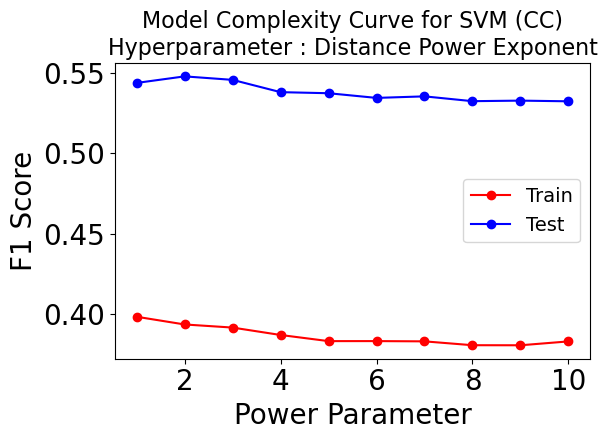

In [31]:
hyperKNN_n(X_train_bank, y_train_bank,X_test_bank,y_test_bank, "Model Complexity Curve for SVM (CC)\nHyperparameter : # of neighbors")
hyperKNN_p(X_train_bank, y_train_bank,X_test_bank,y_test_bank, "Model Complexity Curve for SVM (CC)\nHyperparameter : Distance Power Exponent")

## Automated HPO

In [33]:
%%time
params_knn= {
    'KNN__metric':['manhattan','euclidean'],
    'KNN__n_neighbors':[1,3,5,7,10,13,17,23,29,33,37,43,47,50],
    'KNN__weights':['uniform','distance']
}

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('KNN',KNeighborsClassifier())
])

knn_cv_opt_heart, knn_HPO_Table_heart = hpo(pipeline,X_train_heart,X_test_heart,y_train_heart,y_test_heart, params_knn, 5, 1,100)

Fitting 5 folds for each of 56 candidates, totalling 280 fits
{'KNN__metric': 'manhattan', 'KNN__n_neighbors': 17, 'KNN__weights': 'distance'}
F1 Score Opt: 0.9904153354632589
Wall time: 626 ms


In [124]:
%%time
params_knn= {
    'KNN__metric':['manhattan','euclidean'],
    'KNN__n_neighbors':[1,3,5,7,10,13,17,23,29,33,37,43,47,50],
    'KNN__weights':['uniform','distance']
}

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('KNN',KNeighborsClassifier())
])

knn_cv_opt_bank, knn_HPO_Table_bank = hpo(pipeline,X_train_bank,X_test_bank,y_train_bank,y_test_bank, params_knn, 3, 1 ,100)

Fitting 3 folds for each of 56 candidates, totalling 168 fits


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True

{'KNN__metric': 'euclidean', 'KNN__n_neighbors': 7, 'KNN__weights': 'uniform'}
F1 Score Opt: 0.3986325802615934
Wall time: 40.6 s


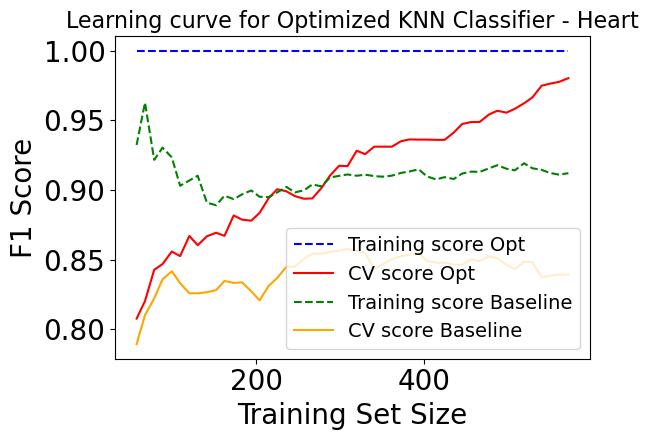

In [140]:
train_opt_knn_heart,val_opt_knn_heart,fit_opt_knn_heart,score_opt_knn_heart = plot_opt_vs_baseline_curves(knn_cv_opt_heart,X_train_heart,X_test_heart,y_train_heart,y_test_heart,5,train_knn_heart_base, val_knn_heart_base, 'Heart','KNN')

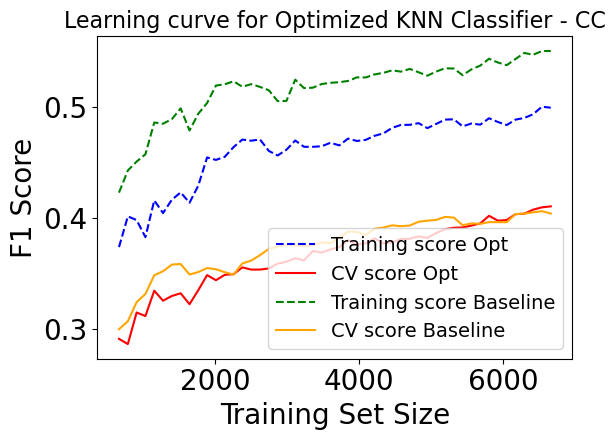

In [141]:
train_opt_knn_bank,val_opt_knn_bank,fit_opt_knn_bank,score_opt_knn_bank = plot_opt_vs_baseline_curves(knn_cv_opt_bank,X_train_bank,X_test_bank,y_train_bank,y_test_bank,3,train_knn_bank_base, val_knn_bank_base, 'CC', 'KNN')

Fitting Time: 0.002960681915283203
Scoring Time: 0.006975650787353516
F1 Score - Heart - Opt - KNN: 0.9904153354632589
              precision    recall  f1-score   support

          No       0.98      1.00      0.99       150
         Yes       1.00      0.98      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



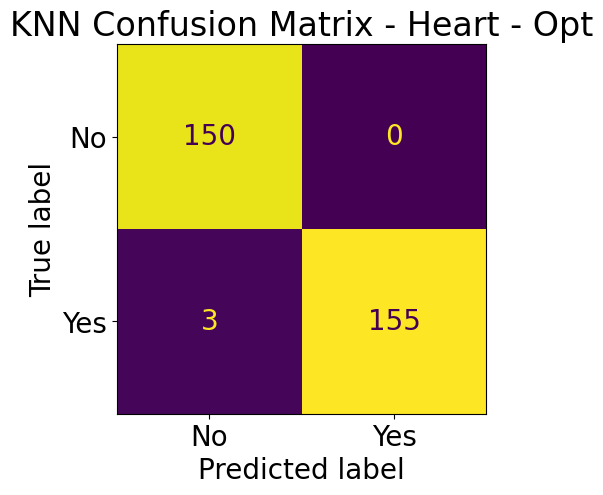

In [129]:
scoring_matrix(knn_cv_opt_heart.best_estimator_,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart - Opt', 'KNN')

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Fitting Time: 0.006975650787353516


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Scoring Time: 3.785351514816284
F1 Score - Bank - Opt - KNN: 0.3986325802615934
              precision    recall  f1-score   support

          No       0.83      0.94      0.88     15576
         Yes       0.58      0.30      0.40      4424

    accuracy                           0.80     20000
   macro avg       0.70      0.62      0.64     20000
weighted avg       0.77      0.80      0.77     20000



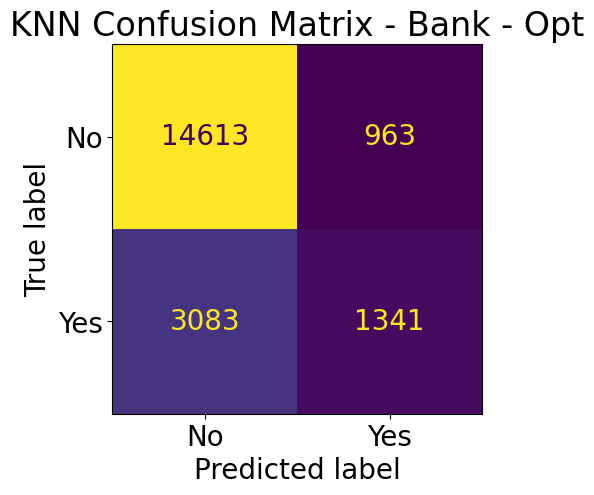

In [130]:
scoring_matrix(knn_cv_opt_bank.best_estimator_,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'Bank - Opt', 'KNN')

## Decision Trees

In [92]:
def dt_baseline_pipeline(X_train,y_train,cv, name, ccp_alpha):
    
    pipeline_unpruned = Pipeline([   
        ('DT',DecisionTreeClassifier(
        random_state = 42
        ))
    ])

    sizes, training_scores_base, val_scores_base, fit_times_base, score_times_base = learning_curve(
        pipeline_unpruned,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )

    # Scoring
    train_mean_base = np.mean(training_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    # Timing
    fit_times_mean_base = np.mean(fit_times_base, axis=1)
    score_times_mean_base = np.mean(score_times_base, axis=1)
    ##############################################################
    pipeline_pruned = Pipeline([   
        ('DT',DecisionTreeClassifier(
        random_state = 42,
        ccp_alpha = ccp_alpha,
        ))
    ])

    sizes, training_scores_pruned, val_scores_pruned, fit_times_pruned, score_times_pruned = learning_curve(
        pipeline_pruned,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    # Scoring
    train_mean_pruned = np.mean(training_scores_pruned, axis=1)
    val_mean_pruned = np.mean(val_scores_pruned, axis=1)
    # Timing
    fit_times_mean_pruned = np.mean(fit_times_pruned, axis=1)
    score_times_mean_pruned = np.mean(score_times_pruned, axis=1)
    
    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean_base, '--', color="b",  label="Training score Base")
    plt.plot(sizes, val_mean_base,color="r", label="CV score Base")
    plt.plot(sizes, train_mean_pruned, '--', color="green",  label="Training score Pruned")
    plt.plot(sizes, val_mean_pruned, color="orange", label="CV score Pruned")

    # Drawing plot
    plt.title("Learning curve for baseline DT Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()


    # Plot the time curves
    # dotted blue line is for training scores and green line is for cross-validation score
    plt.plot(sizes, fit_times_mean_base, '--', color="b",  label="Fit Time Base")
    plt.plot(sizes, score_times_mean_base, color="r", label="Score Time Base")
    plt.plot(sizes, fit_times_mean_pruned, '--', color="green",  label="Fit Time Pruned")
    plt.plot(sizes, score_times_mean_pruned, color="orange", label="Score Time Pruned")

    # Drawing plot
    plt.title("Time Complexity for baseline DT Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Time Taken [s]"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    return train_mean_base, val_mean_base, fit_times_mean_base, score_times_mean_base

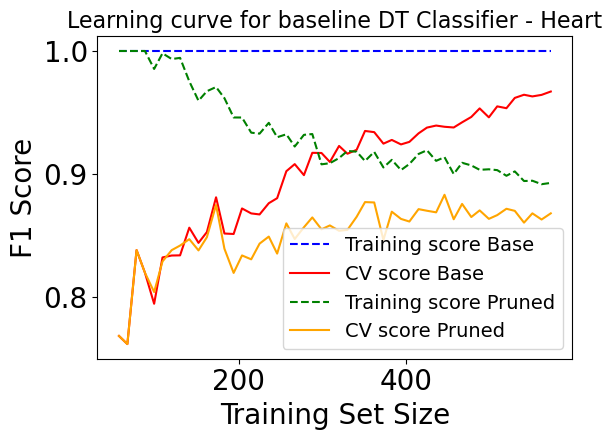

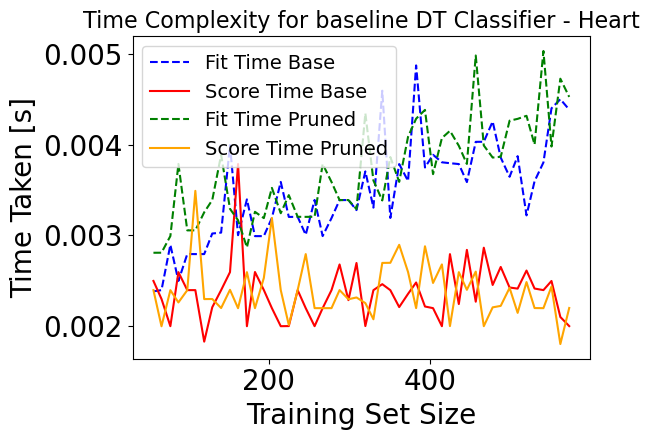

Wall time: 1.01 s


In [93]:
%%time
train_dt_heart_base, val_dt_heart_base, fit_dt_heart_base, score_dt_heart_base = dt_baseline_pipeline(X_train_heart,y_train_heart,5, 'Heart',0.01)

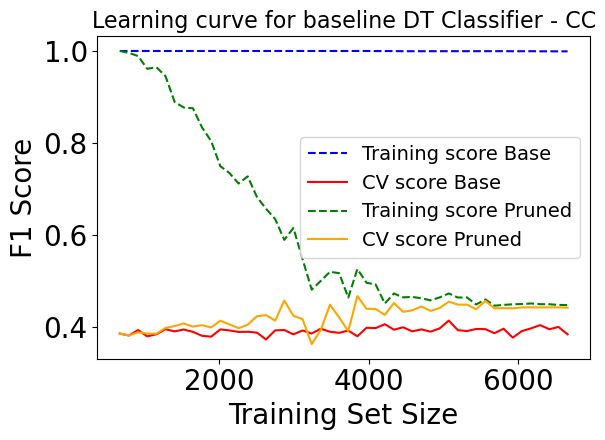

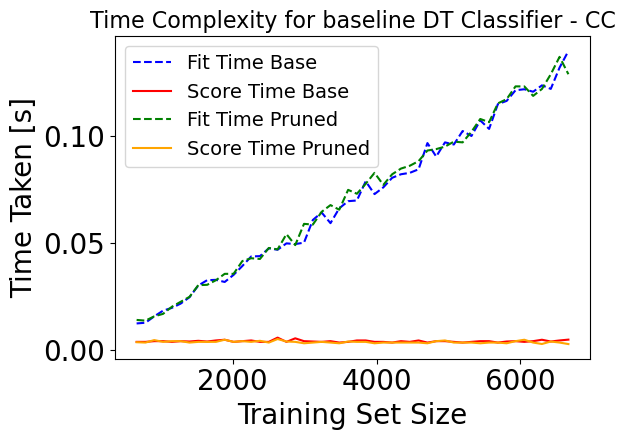

Wall time: 3.64 s


In [94]:
%%time
train_dt_bank_base, val_dt_bank_base, fit_dt_bank_base, score_dt_bank_base = dt_baseline_pipeline(X_train_bank,y_train_bank,3, 'CC',0.001)

## Test Results

Fitting Time: 0.002989530563354492
Scoring Time: 0.0009968280792236328
F1 Score - Heart - DT: 0.9806451612903226
              precision    recall  f1-score   support

          No       0.96      1.00      0.98       150
         Yes       1.00      0.96      0.98       158

    accuracy                           0.98       308
   macro avg       0.98      0.98      0.98       308
weighted avg       0.98      0.98      0.98       308



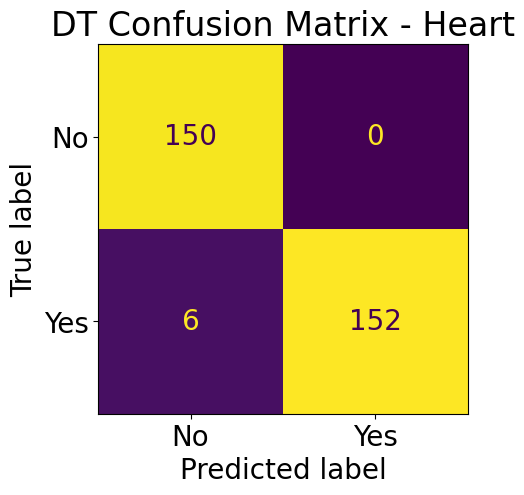

Fitting Time: 0.1346750259399414
Scoring Time: 0.003987550735473633
F1 Score - CC - DT: 0.3993852234054232
              precision    recall  f1-score   support

          No       0.83      0.82      0.82     15576
         Yes       0.39      0.41      0.40      4424

    accuracy                           0.73     20000
   macro avg       0.61      0.61      0.61     20000
weighted avg       0.73      0.73      0.73     20000



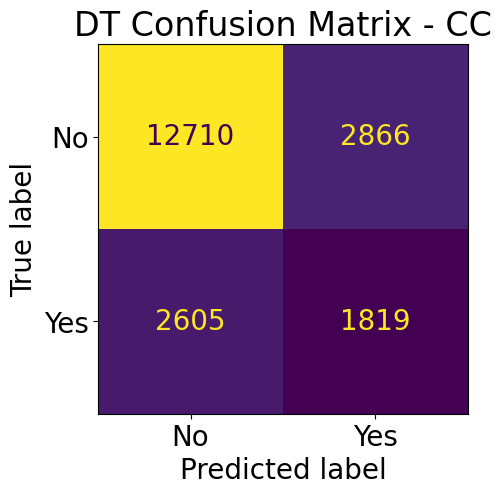

In [47]:
pipeline = Pipeline([   
        ('DT',DecisionTreeClassifier(
        random_state = 42
        ))
])

scoring_matrix(pipeline,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart', 'DT')
scoring_matrix(pipeline,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC', 'DT')

## Hyperparameter Tuning

In [50]:
def hyperTree_leaves(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    min_leaves = list(range(1,50))
    for i in min_leaves:         
            clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=i)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(min_leaves, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(min_leaves, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('Min samples per leaf')
    
    plt.title(title)
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
def hyperTree_ccp(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    ccp_alpha = [0,0.001,0.01,0.02,0.03,0.04,0.05,0.1]
    for i in ccp_alpha:         
            clf = DecisionTreeClassifier(random_state=42, ccp_alpha=i)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
            
    plt.plot(ccp_alpha, f1_train, 'o-', color = 'b', label='Train', alpha =0.8)      
    plt.plot(ccp_alpha, f1_test, 'o-', color='r', label='Test', alpha =0.8)

    plt.ylabel('F1 Score')
    plt.xlabel('ccp_alpha')
    
    plt.title(title)
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    
def hyperTree_depth(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,50))
    for i in max_depth:         
            clf = DecisionTreeClassifier(random_state=42, max_depth=i)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('Max depth')
    
    plt.title(title)
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()

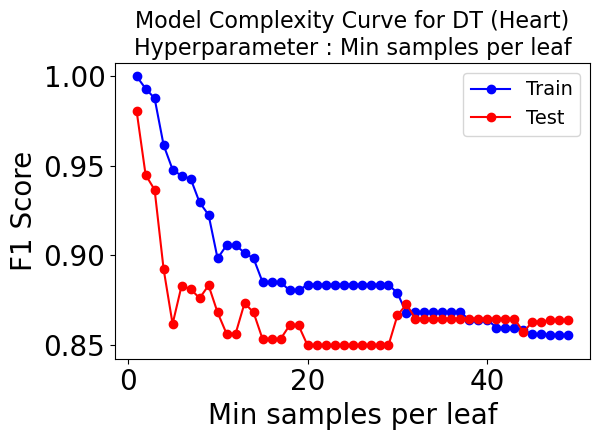

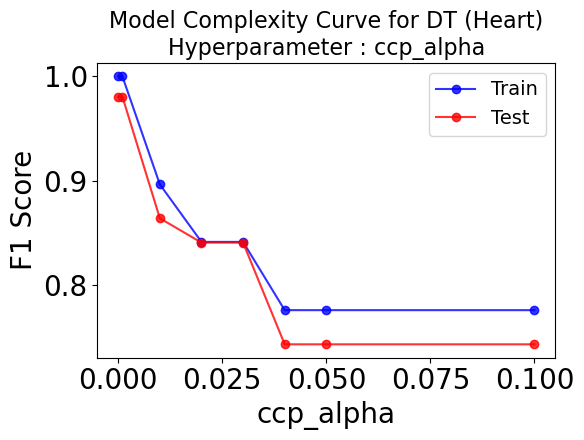

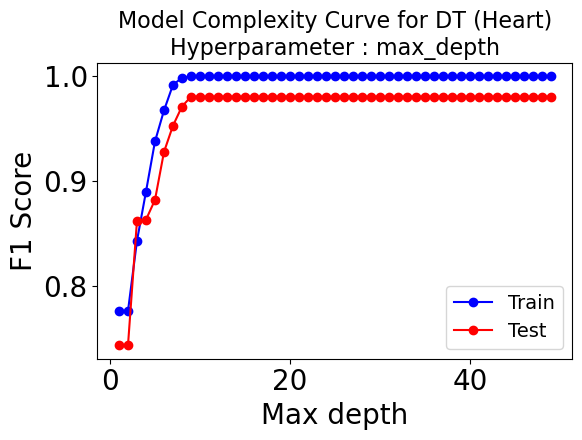

In [51]:
hyperTree_leaves(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for DT (Heart)\nHyperparameter : Min samples per leaf")
hyperTree_ccp(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for DT (Heart)\nHyperparameter : ccp_alpha")
hyperTree_depth(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for DT (Heart)\nHyperparameter : max_depth")

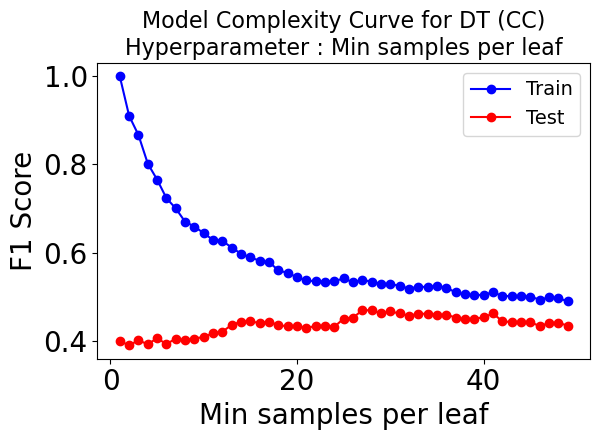

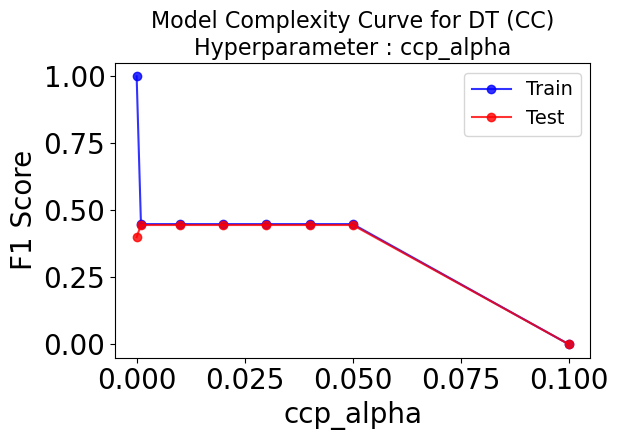

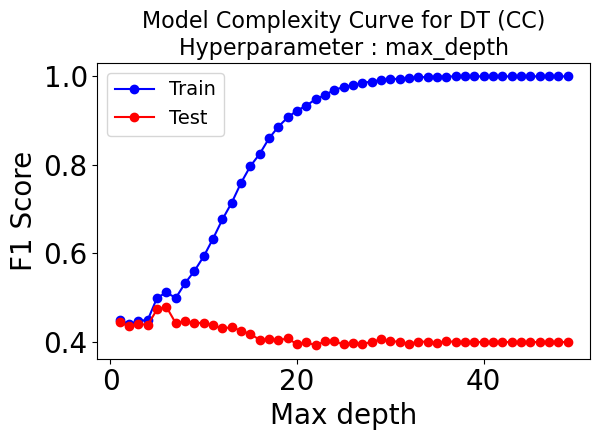

In [53]:
hyperTree_leaves(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for DT (CC)\nHyperparameter : Min samples per leaf")
hyperTree_ccp(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for DT (CC)\nHyperparameter : ccp_alpha")
hyperTree_depth(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for DT (CC)\nHyperparameter : max_depth")

## Automated HPO

In [100]:
%%time
params_DT= {
    'DT__max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,None],
    'DT__min_samples_split': [2,3,4,5,6,7,8,9,10],
    'DT__min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
    'DT__ccp_alpha':[0,0.0001,0.001,0.01],
}

pipeline = Pipeline([   
    ('DT', DecisionTreeClassifier(random_state = 42))
])

dt_cv_opt_heart, dt_HPO_Table_heart = hpo(pipeline,X_train_heart,X_test_heart,y_train_heart,y_test_heart, params_DT, 5, 1,100)

Fitting 5 folds for each of 8400 candidates, totalling 42000 fits
{'DT__ccp_alpha': 0, 'DT__max_depth': 8, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
F1 Score Opt: 0.9712460063897763
Wall time: 51.3 s


In [79]:
pipeline = Pipeline([    
    ('DT', DecisionTreeClassifier(random_state = 42))
])

dt_cv_opt_bank, dt_HPO_Table_bank = hpo(pipeline,X_train_bank,X_test_bank,y_train_bank,y_test_bank, params_DT, 3, 1,100)

Fitting 3 folds for each of 8400 candidates, totalling 25200 fits
{'DT__ccp_alpha': 0, 'DT__max_depth': 6, 'DT__min_samples_leaf': 1, 'DT__min_samples_split': 2}
F1 Score Opt: 0.4785311551250543


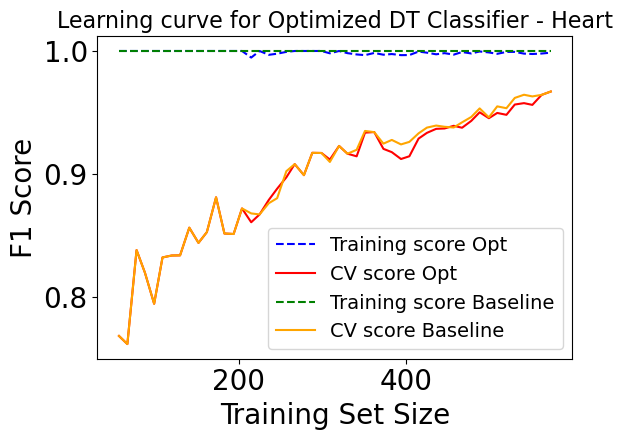

In [142]:
train_opt_dt_heart,val_opt_dt_heart,fit_opt_dt_heart,score_opt_dt_heart = plot_opt_vs_baseline_curves(dt_cv_opt_heart,X_train_heart,X_test_heart,y_train_heart,y_test_heart,5,train_dt_heart_base, val_dt_heart_base, 'Heart','DT')

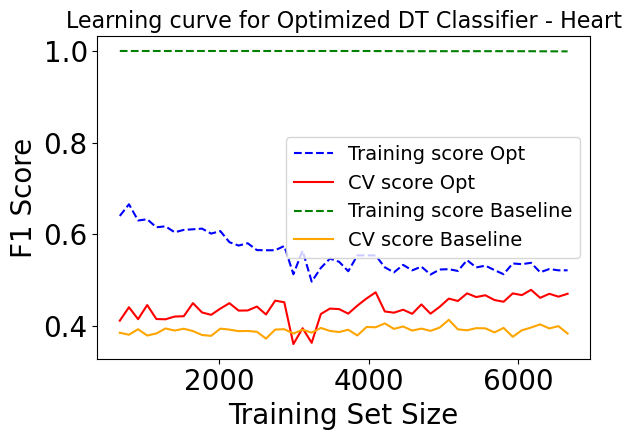

In [143]:
train_opt_dt_bank,val_opt_dt_bank,fit_opt_dt_bank,score_opt_dt_bank = plot_opt_vs_baseline_curves(dt_cv_opt_bank,X_train_bank,X_test_bank,y_train_bank,y_test_bank,3,train_dt_bank_base, val_dt_bank_base, 'CC','DT')

Fitting Time: 0.0029256343841552734
Scoring Time: 0.0020051002502441406
F1 Score - Heart Opt - DT: 0.9712460063897763
              precision    recall  f1-score   support

          No       0.96      0.98      0.97       150
         Yes       0.98      0.96      0.97       158

    accuracy                           0.97       308
   macro avg       0.97      0.97      0.97       308
weighted avg       0.97      0.97      0.97       308



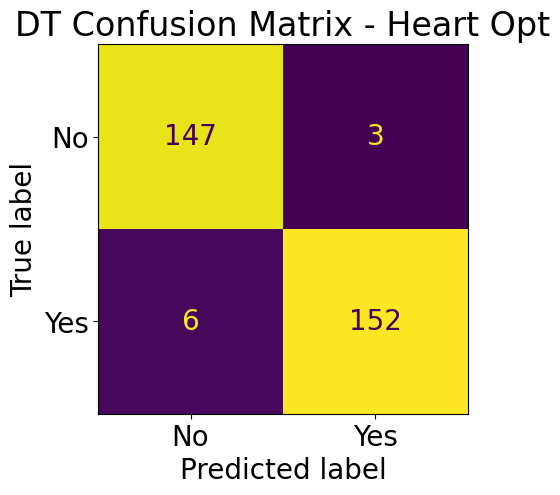

In [101]:
scoring_matrix(dt_cv_opt_heart.best_estimator_,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart Opt', 'DT')

Fitting Time: 0.05740046501159668
Scoring Time: 0.004909038543701172
F1 Score - Bank Opt - DT: 0.4785311551250543
              precision    recall  f1-score   support

          No       0.84      0.95      0.89     15576
         Yes       0.66      0.37      0.48      4424

    accuracy                           0.82     20000
   macro avg       0.75      0.66      0.68     20000
weighted avg       0.80      0.82      0.80     20000



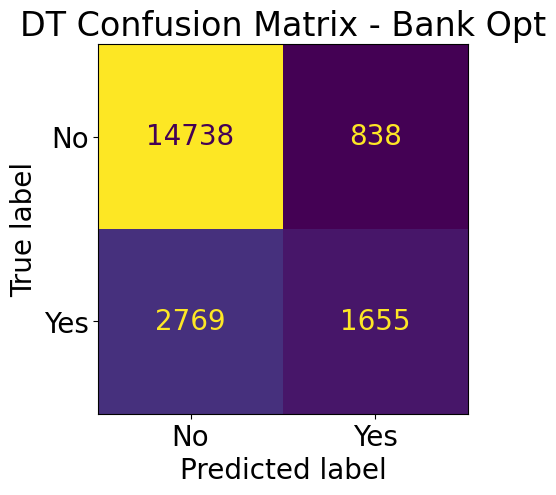

In [99]:
scoring_matrix(dt_cv_opt_bank.best_estimator_,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'Bank Opt', 'DT')

## Boosted Trees

In [64]:
def bt_baseline_pipeline(X_train,y_train,cv, name):

    pipeline_unpruned = Pipeline([             
        ('BT',AdaBoostClassifier(
        random_state = 42,
        base_estimator = DecisionTreeClassifier(random_state = 42, max_depth=None)
        ))
    ])

    sizes, training_scores_unpruned, val_scores_unpruned, fit_times_unpruned, score_times_unpruned = learning_curve(
        pipeline_unpruned,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    
    #Scores
    train_mean_unpruned = np.mean(training_scores_unpruned, axis=1)
    val_mean_unpruned = np.mean(val_scores_unpruned, axis=1)
    #Times
    fit_times_mean_unpruned = np.mean(fit_times_unpruned, axis=1)
    score_times_mean_unpruned = np.mean(score_times_unpruned, axis=1)

    pipeline_heart_pruned = Pipeline([             
        ('BT',AdaBoostClassifier(
        random_state = 42,
        base_estimator = DecisionTreeClassifier(random_state = 42, max_depth=1)
        ))
    ])

    # Get the learning curves of the data with 5 fold CV

    sizes, training_scores_pruned, val_scores_pruned, fit_times_pruned, score_times_pruned = learning_curve(
        pipeline_heart_pruned,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    #Scores
    train_mean_pruned = np.mean(training_scores_pruned, axis=1)
    val_mean_pruned = np.mean(val_scores_pruned, axis=1)
    #Timing
    fit_times_mean_pruned = np.mean(fit_times_pruned, axis=1)
    score_times_mean_pruned = np.mean(score_times_pruned, axis=1)

    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean_unpruned, '--', color="b",  label="Training score Unpruned")
    plt.plot(sizes, val_mean_unpruned, color="r", label="CV score Unpruned")
    plt.plot(sizes, train_mean_pruned, '--', color="g",  label="Training score Base (Pruned)")
    plt.plot(sizes, val_mean_pruned, color="orange", label="CV score Base(Pruned)")

    # Drawing plot
    plt.title("Learning curve for baseline AdaBoost Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()

    plt.plot(sizes, fit_times_mean_unpruned, '--', color="b",  label="Fit Time Unpruned")
    plt.plot(sizes, score_times_mean_unpruned, color="r", label="Score Time Unpruned")
    plt.plot(sizes, fit_times_mean_pruned, '--', color="g",  label="Fit Time Base (Pruned)")
    plt.plot(sizes, score_times_mean_pruned, color="orange", label="Score Time Base (Pruned)")

    # # Drawing plot
    plt.title("Time Complexity for baseline AdaBoost Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Time Taken [s]"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    return train_mean_pruned, val_mean_pruned, fit_times_mean_pruned, score_times_mean_pruned

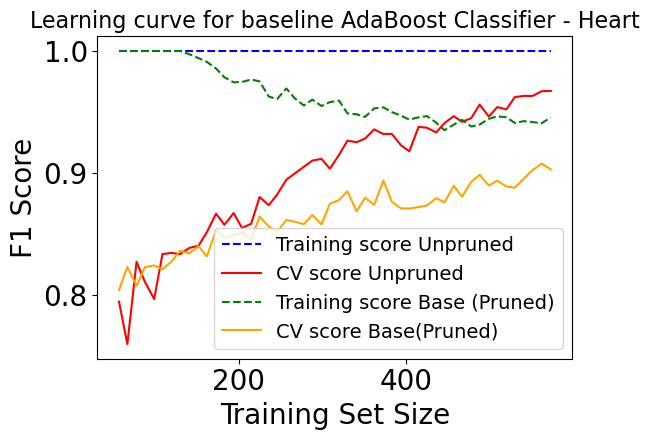

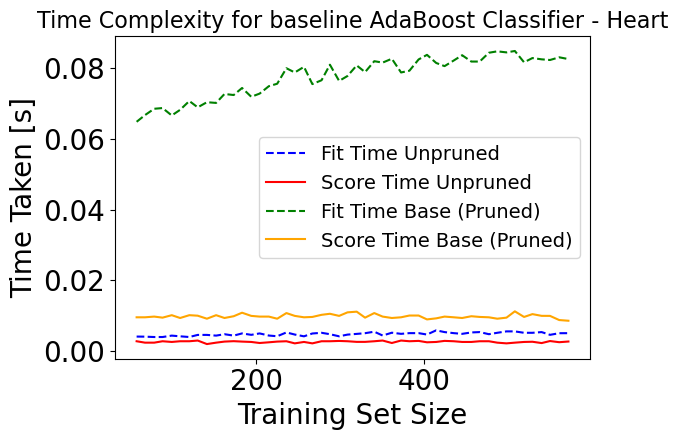

Wall time: 3.89 s


In [65]:
%%time
train_bt_heart_base, val_bt_heart_base, fit_bt_heart_base, score_bt_heart_base = bt_baseline_pipeline(X_train_heart,y_train_heart,5, 'Heart')

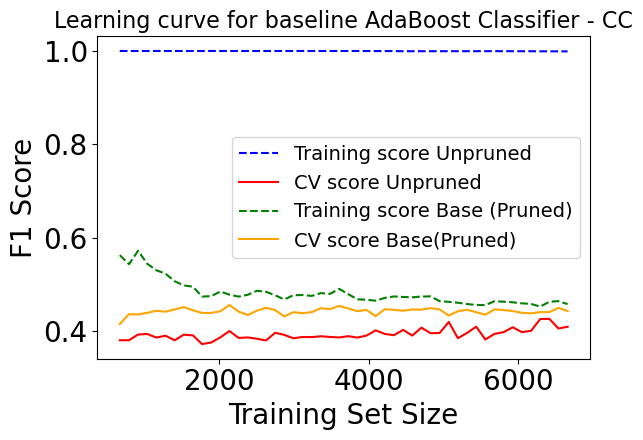

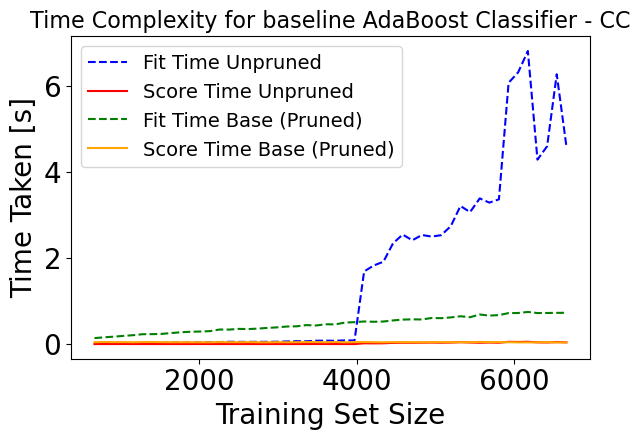

Wall time: 45 s


In [68]:
%%time
train_bt_bank_base, val_bt_bank_base, fit_bt_bank_base, score_bt_bank_base  = bt_baseline_pipeline(X_train_bank,y_train_bank,3, 'CC')

## Test Results

Fitting Time: 0.057798147201538086
Scoring Time: 0.006058216094970703
F1 Score - Heart - BT: 0.8924050632911392
              precision    recall  f1-score   support

          No       0.89      0.89      0.89       150
         Yes       0.89      0.89      0.89       158

    accuracy                           0.89       308
   macro avg       0.89      0.89      0.89       308
weighted avg       0.89      0.89      0.89       308



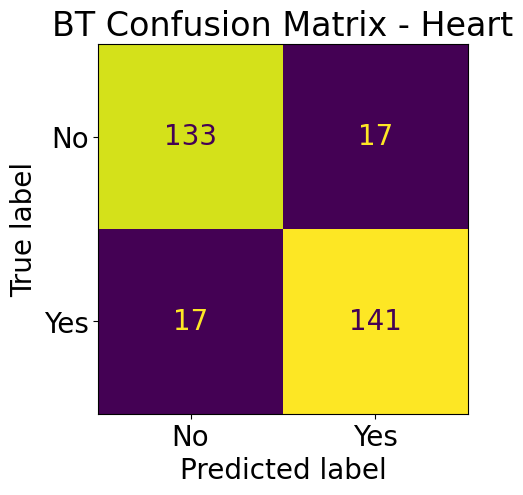

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Time: 0.5825643539428711
Scoring Time: 0.12135529518127441
F1 Score - CC - BT: 0.4267743438422115
              precision    recall  f1-score   support

          No       0.83      0.96      0.89     15576
         Yes       0.68      0.31      0.43      4424

    accuracy                           0.82     20000
   macro avg       0.76      0.63      0.66     20000
weighted avg       0.80      0.82      0.79     20000



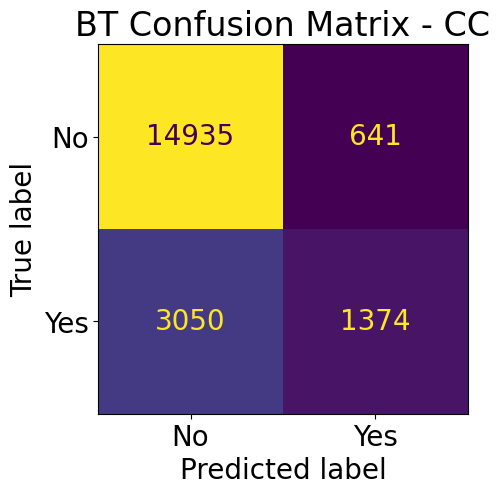

In [67]:
pipeline = Pipeline([   
        ('BT',AdaBoostClassifier(
        random_state = 42
        ))
])

scoring_matrix(pipeline,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart', 'BT')
scoring_matrix(pipeline,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC', 'BT')

## Hyperparameter Tuning

In [69]:
def hyperBoost_n(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    n_estimator = [10,20,30,40,50,60,70,80,90,100,200,300,400,500,600,700,800,900,1000]
    for i in n_estimator:         
            clf = AdaBoostClassifier(random_state=42, n_estimators=i)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimator, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(n_estimator, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('n_estimator')
    
    plt.title(title)
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    
def hyperBoost_lr(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    lr = [0.001,0.01,0.1,1,1.2,1.5,2,5,10]
    for i in lr:         
            clf = AdaBoostClassifier(random_state=42, learning_rate=i)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(lr, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(lr, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('learning rate')
    
    plt.title(title)
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()    

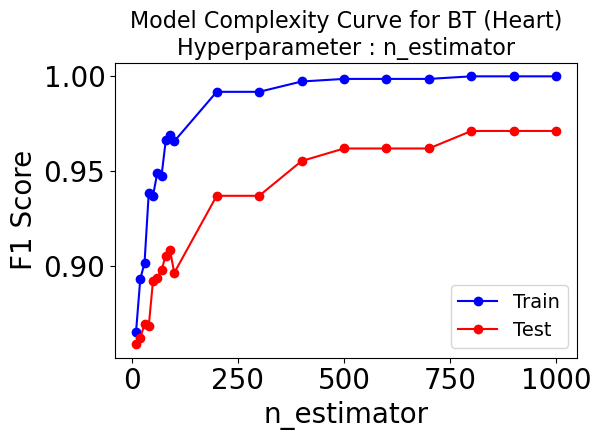

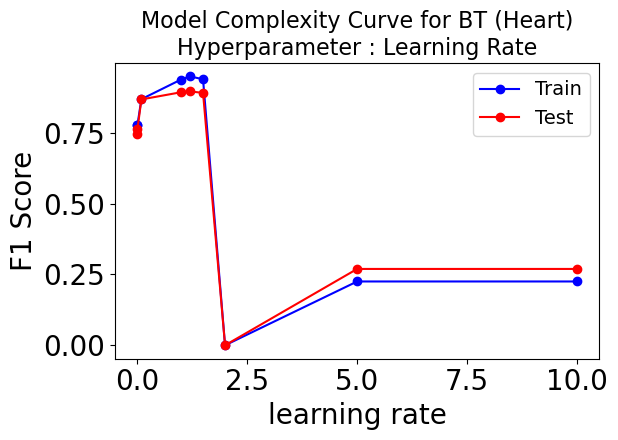

Wall time: 8.14 s


In [70]:
%%time
hyperBoost_n(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for BT (Heart)\nHyperparameter : n_estimator")
hyperBoost_lr(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for BT (Heart)\nHyperparameter : Learning Rate")

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

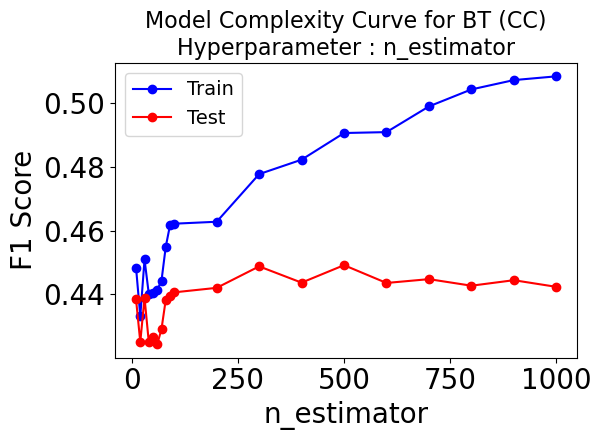

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

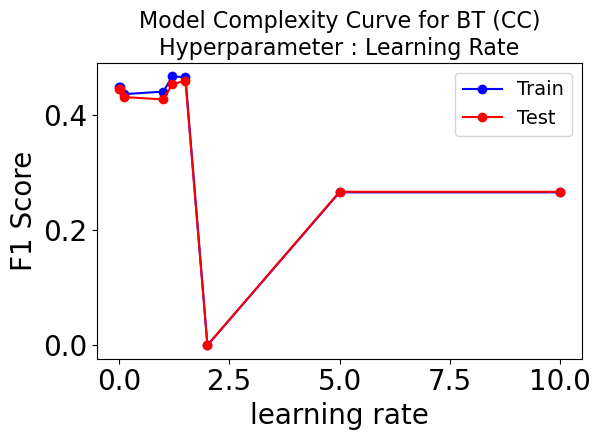

Wall time: 1min 34s


In [71]:
%%time
hyperBoost_n(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for BT (CC)\nHyperparameter : n_estimator")
hyperBoost_lr(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for BT (CC)\nHyperparameter : Learning Rate")

## Automated HPO

In [102]:
params_BT= {
    'BT__n_estimators':[50,100,200,300,400,500,600,700,800,900,1000],
    'BT__learning_rate': [0.001,0.01,0.1,1,1.2,1.5,2,5,10]
}


pipeline = Pipeline([   
    ('BT', AdaBoostClassifier(random_state = 42))
])

bt_cv_opt_heart, bt_HPO_Table_heart = hpo(pipeline,X_train_heart,X_test_heart,y_train_heart,y_test_heart, params_BT, 5, 1,100)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
{'BT__learning_rate': 1.5, 'BT__n_estimators': 600}
F1 Score Opt: 0.9712460063897763


In [103]:
%%time
pipeline = Pipeline([   
    ('BT', AdaBoostClassifier(random_state = 42))
])

bt_cv_opt_bank, bt_HPO_Table_bank = hpo(pipeline,X_train_bank,X_test_bank,y_train_bank,y_test_bank, params_BT, 3, 1,100)

Fitting 3 folds for each of 99 candidates, totalling 297 fits


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'BT__learning_rate': 1.2, 'BT__n_estimators': 200}
F1 Score Opt: 0.4487045080125805
Wall time: 5min 14s


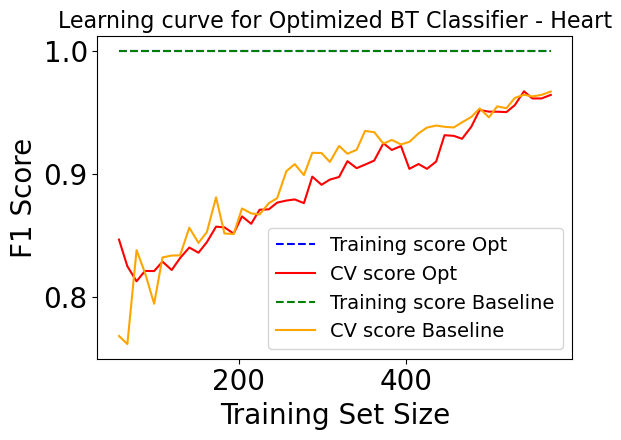

In [144]:
train_opt_bt_heart,val_opt_bt_heart,fit_opt_bt_heart,score_opt_bt_heart = plot_opt_vs_baseline_curves(bt_cv_opt_heart,X_train_heart,X_test_heart,y_train_heart,y_test_heart,5,train_dt_heart_base, val_dt_heart_base, 'Heart','BT')

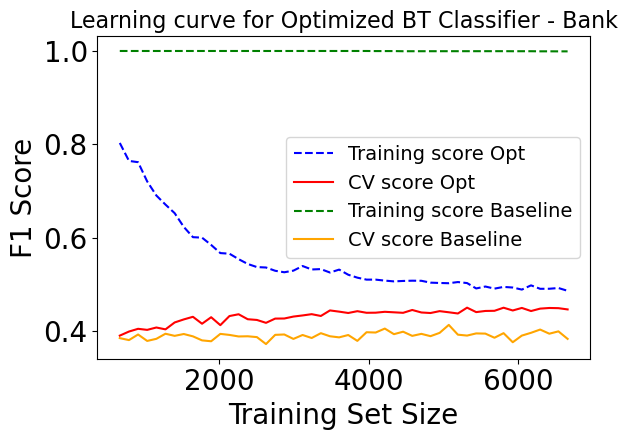

In [145]:
train_opt_bt_bank,val_opt_bt_bank,fit_opt_bt_bank,score_opt_bt_bank = plot_opt_vs_baseline_curves(bt_cv_opt_bank,X_train_bank,X_test_bank,y_train_bank,y_test_bank,3,train_dt_bank_base, val_dt_bank_base, 'Bank','BT')

Fitting Time: 0.5965297222137451
Scoring Time: 0.05832695960998535
F1 Score - Heart Opt - BT: 0.9712460063897763
              precision    recall  f1-score   support

          No       0.96      0.98      0.97       150
         Yes       0.98      0.96      0.97       158

    accuracy                           0.97       308
   macro avg       0.97      0.97      0.97       308
weighted avg       0.97      0.97      0.97       308



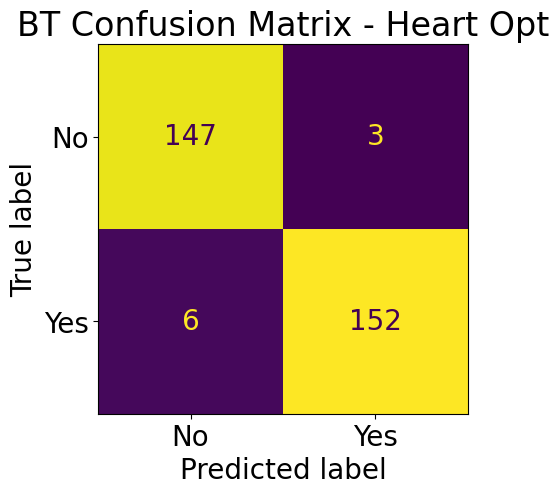

In [106]:
scoring_matrix(bt_cv_opt_heart.best_estimator_,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart Opt', 'BT')

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Time: 2.375185012817383
Scoring Time: 0.4955918788909912
F1 Score - Bank Opt - BT: 0.4487045080125805
              precision    recall  f1-score   support

          No       0.84      0.95      0.89     15576
         Yes       0.66      0.34      0.45      4424

    accuracy                           0.82     20000
   macro avg       0.75      0.65      0.67     20000
weighted avg       0.80      0.82      0.79     20000



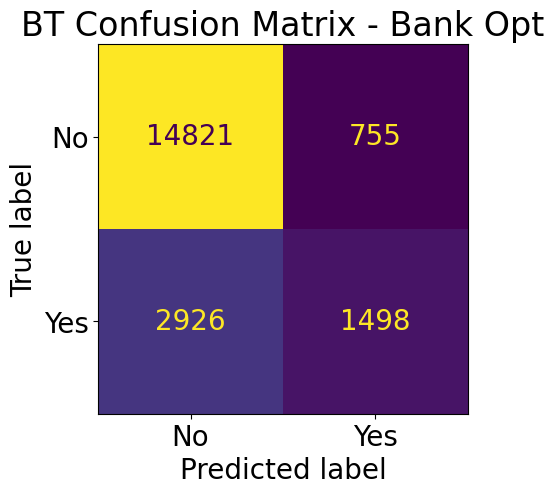

In [107]:
scoring_matrix(bt_cv_opt_bank.best_estimator_,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'Bank Opt', 'BT')

## ANN

In [152]:
def ann_baseline_pipeline(X_train,y_train,cv, name,batch):
    pipeline_base = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('ANN',MLPClassifier(random_state=42, batch_size = batch))
    ])

    sizes, training_scores_base, val_scores_base, fit_times_base, score_times_base = learning_curve(
        pipeline_base,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    #Score
    train_mean_base = np.mean(training_scores_base, axis=1)
    val_mean_base = np.mean(val_scores_base, axis=1)
    #Timing
    fit_times_mean_base = np.mean(fit_times_base, axis=1)
    score_times_mean_base = np.mean(score_times_base, axis=1)

    ##############################################################
    pipeline_complex = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('ANN',MLPClassifier(random_state=42,hidden_layer_sizes =(100,100,100,), batch_size = batch))

    ])

    sizes, training_scores_complex, val_scores_complex, fit_times_complex, score_times_complex = learning_curve(
        pipeline_complex,
        X_train, y_train,
        cv = cv,
        scoring='f1',
        n_jobs = -1,
        train_sizes=np.linspace(0.1, 1.0, 50),
        return_times =True,
        random_state = 42
    )
    
    #Score
    train_mean_3 = np.mean(training_scores_complex, axis=1)
    val_mean_3 = np.mean(val_scores_complex, axis=1)
    #Time
    fit_times_mean_3 = np.mean(fit_times_complex, axis=1)
    score_times_mean_3 = np.mean(score_times_complex, axis=1)
    
    # dotted blue line is for training scores and red line is for cross-validation score
    plt.plot(sizes, train_mean_base, '--', color="b",  label="Training score Base")
    plt.plot(sizes, val_mean_base, color="r", label="CV score Base")
    plt.plot(sizes, train_mean_3, '--', color="g",  label="Training score 3 layer")
    plt.plot(sizes, val_mean_3,color="orange", label="CV score 3 layer")

    # Drawing plot
    plt.title("Learning curve for baseline ANN Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("F1 Score"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()

    # dotted blue line is for training scores and green line is for cross-validation score
    plt.plot(sizes, fit_times_mean_base, '--', color="b",  label="Fit Time Base")
    plt.plot(sizes, score_times_mean_base, color="r", label="Score Time Base")
    plt.plot(sizes, fit_times_mean_3, '--', color="g",  label="Fit Time 3 layer")
    plt.plot(sizes, score_times_mean_3, color="orange", label="Score Time 3 layer")

    # Drawing plot
    plt.title("Time Complexity for baseline ANN Classifier - "+name,fontsize = 16)
    plt.xlabel("Training Set Size"), plt.ylabel("Time Taken [s]"), plt.legend(loc="best",prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    return train_mean_base, val_mean_base, fit_times_mean_base, score_times_mean_base

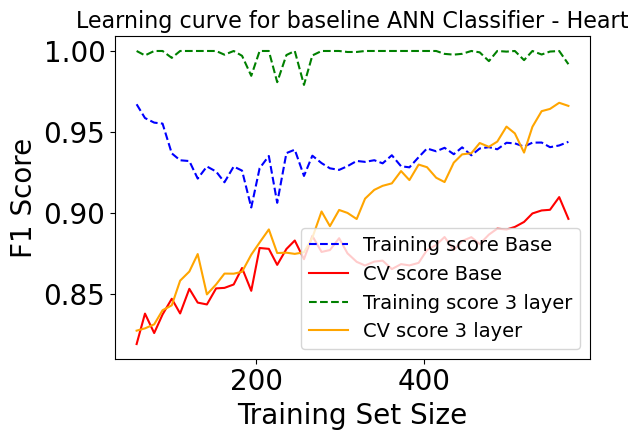

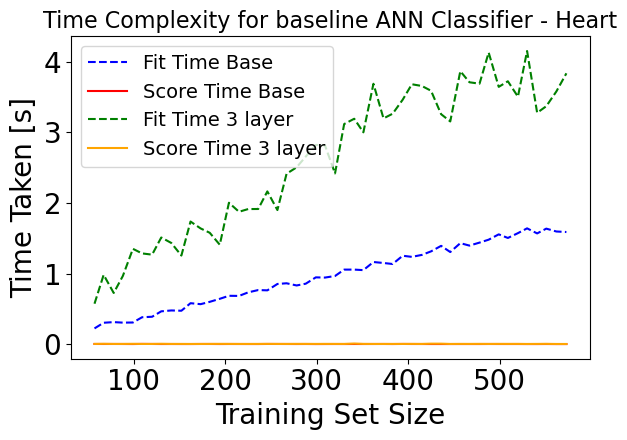

Wall time: 1min 56s


In [153]:
%%time
train_ann_heart_base, val_ann_heart_base, fit_ann_heart_base, score_ann_heart_base = ann_baseline_pipeline(X_train_heart,y_train_heart,5, 'Heart',32)

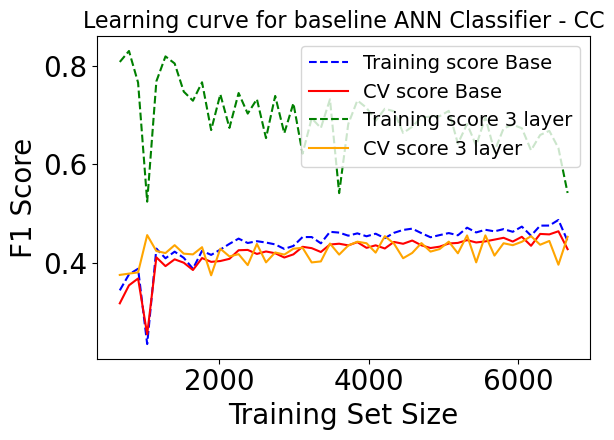

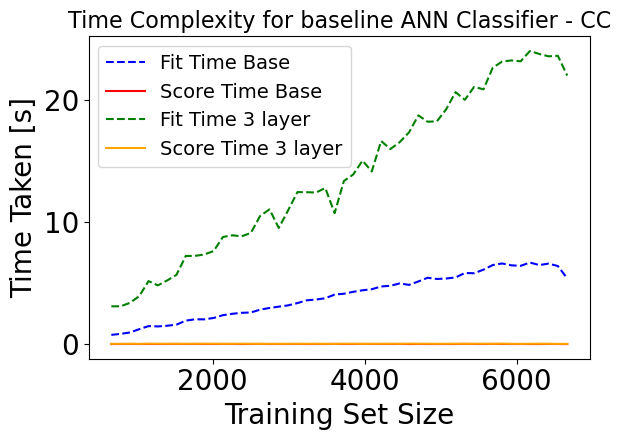

Wall time: 5min 43s


In [154]:
%%time
train_ann_bank_base, val_ann_bank_base, fit_ann_bank_base, score_ann_bank_base = ann_baseline_pipeline(X_train_bank,y_train_bank,3, 'CC',512)

## Test Results

Fitting Time: 0.895362377166748
Scoring Time: 0.0010039806365966797
F1 Score - Heart - ANN: 0.9358974358974359
              precision    recall  f1-score   support

          No       0.92      0.95      0.93       150
         Yes       0.95      0.92      0.94       158

    accuracy                           0.94       308
   macro avg       0.94      0.94      0.94       308
weighted avg       0.94      0.94      0.94       308



C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


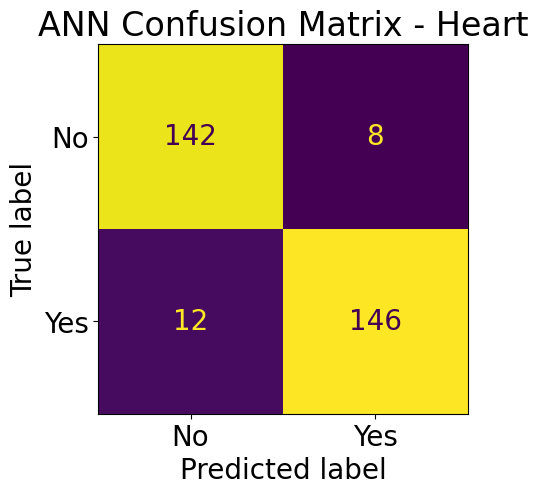

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Time: 3.9574389457702637
Scoring Time: 0.017482995986938477
F1 Score - CC - ANN: 0.47407407407407415
              precision    recall  f1-score   support

          No       0.84      0.95      0.89     15576
         Yes       0.66      0.37      0.47      4424

    accuracy                           0.82     20000
   macro avg       0.75      0.66      0.68     20000
weighted avg       0.80      0.82      0.80     20000



C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


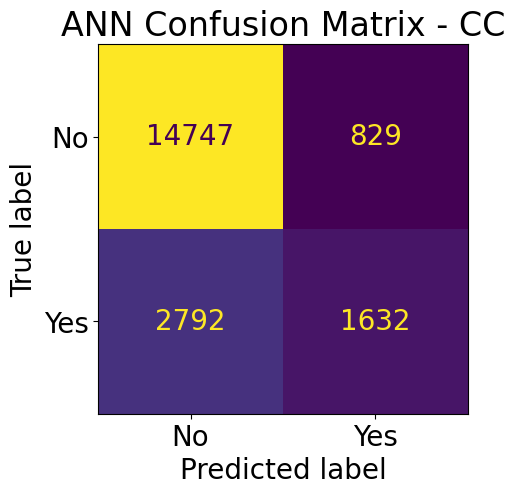

In [117]:
pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('ANN',MLPClassifier(random_state=42, batch_size = 32))
])

scoring_matrix(pipeline,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart', 'ANN')

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('ANN',MLPClassifier(random_state=42, batch_size = 512))
])

scoring_matrix(pipeline,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC', 'ANN')

## Learning Curves - Epoch

In [118]:
def epoch_loss_plots(batch,X_train, y_train,name,test_size):
    pipeline_heart = Pipeline([   
        ('Scale',MinMaxScaler()), 
        ('ANN',MLPClassifier(random_state=42, batch_size =batch,
                            ))

    ])

    X_train_train, X_test_train, y_train_train, y_test_train = train_test_split(X_train, y_train,
                                                        test_size = test_size, random_state = 1, stratify = y_train
                                                       )

    pipeline_heart.fit(X_train_train, y_train_train)
    ax = plt.gca()
    plt.plot(pipeline_heart.steps[1][1].loss_curve_,  label="Training Error")
    pipeline_heart.fit(X_test_train, y_test_train)
    plt.plot(pipeline_heart.steps[1][1].loss_curve_, label ='Validation Error')
    plt.title('Loss Curves - '+name,fontsize = 16)
    plt.xlabel("Epochs"), plt.ylabel("Loss Values"), plt.legend(loc="best",prop={'size': 14})

    plt.show()

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


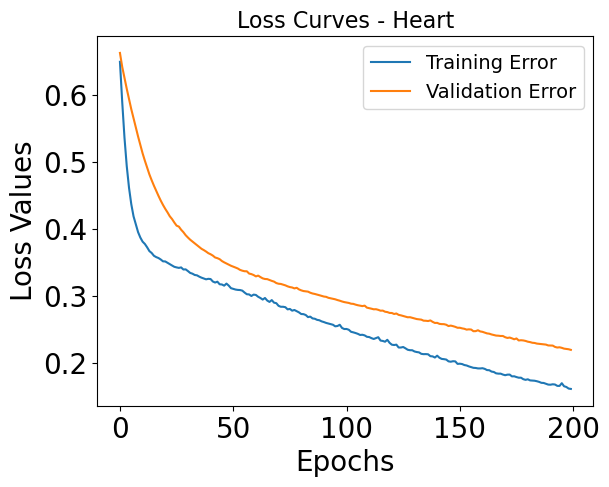

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

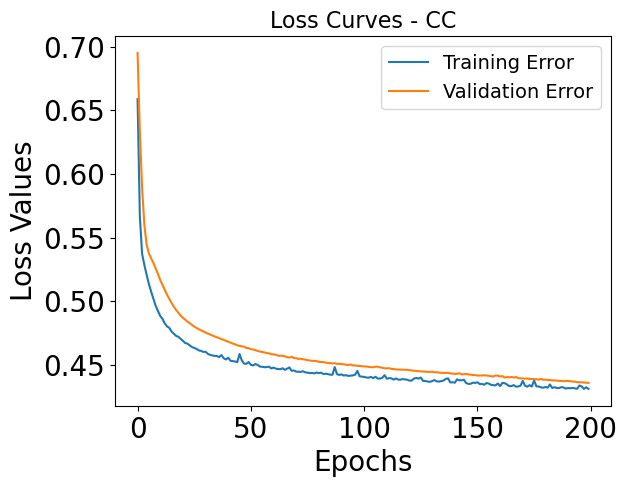

Wall time: 4.99 s


In [119]:
%%time
epoch_loss_plots(32,X_train_heart, y_train_heart,'Heart',0.2)
epoch_loss_plots(512,X_train_bank, y_train_bank,'CC',(1/3))

## Hyperparameter Tuning

In [120]:
def hyperANN_nodes(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    hlist = np.linspace(5,300,60).astype('int')
    for i in hlist:
        clf = Pipeline([   
            ('Scale',MinMaxScaler()), 
            ('ANN',MLPClassifier(hidden_layer_sizes=(i,), random_state =42))
        ])
        
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(hlist, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(hlist, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('Nodes in single hidden layer')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()
    
    
def hyperANN_alpha(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    alist = [0.0001,0.001,0.01,0.1,0.5]
    for i in alist:
        clf = Pipeline([   
            ('Scale',MinMaxScaler()), 
            ('ANN',MLPClassifier(alpha =i, random_state =42))
        ])
        
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(alist, f1_train, 'o-', color = 'b', label='Train')
    plt.plot(alist, f1_test, 'o-', color='r', label='Test')

    plt.ylabel('F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title,fontsize = 16)
    plt.legend(loc='best',prop={'size': 14})
    plt.tight_layout()
    plt.show()

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_netw

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_netw

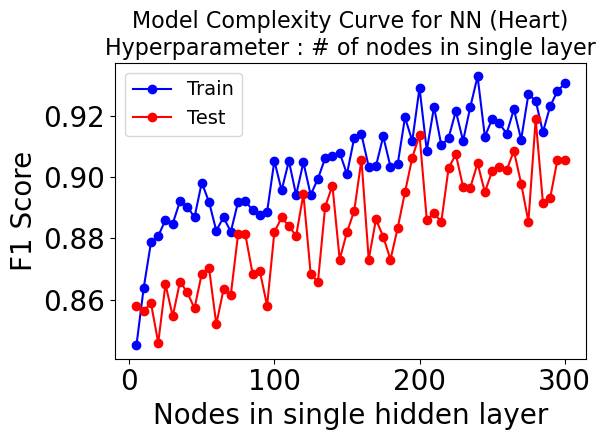

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_netw

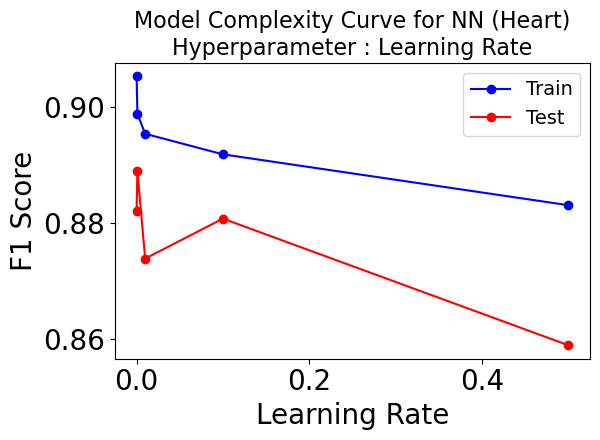

Wall time: 31.7 s


In [122]:
%%time
hyperANN_nodes(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for NN (Heart)\nHyperparameter : # of nodes in single layer")
hyperANN_alpha(X_train_heart, y_train_heart, X_test_heart, y_test_heart,title="Model Complexity Curve for NN (Heart)\nHyperparameter : Learning Rate")

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example us

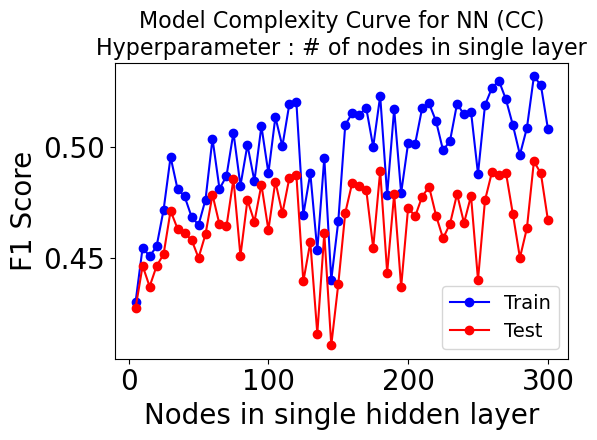

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimi

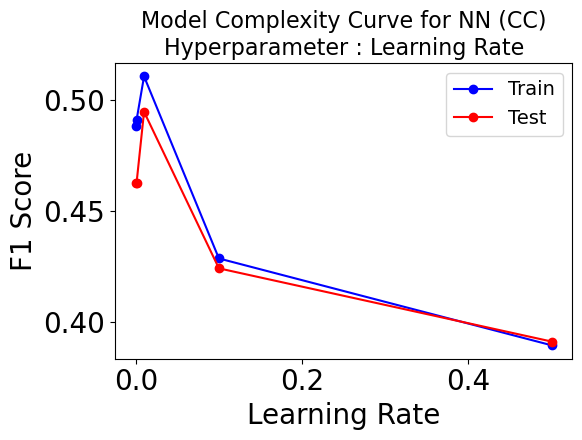

Wall time: 7min 55s


In [123]:
%%time
hyperANN_nodes(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for NN (CC)\nHyperparameter : # of nodes in single layer")
hyperANN_alpha(X_train_bank, y_train_bank, X_test_bank, y_test_bank,title="Model Complexity Curve for NN (CC)\nHyperparameter : Learning Rate")

## Automated HPO

In [133]:
%%time
hidden_layer = [(50,),(50,50,),(50,50,50),
                (100,),(100,100,),(100,100,100),
                (150,),(150,150,),(150,150,150),
                (200,),(200,200,),(200,200,200),
                (250,),(250,250,),(250,250,250),
                (300,),(300,300,),(300,300,300)]
alphas = [0.0001,0.001,0.01,0.1,0.5,1]

params_ANN= {
    'ANN__activation':['relu','logistic','tanh'],
    'ANN__alpha':alphas,
    'ANN__hidden_layer_sizes':hidden_layer,
    
}

pipeline = Pipeline([   
    ('Scale',MinMaxScaler()), 
    ('ANN',MLPClassifier(random_state=42, 
                         batch_size =32,
                        ))

])

ann_cv_opt_heart, ann_HPO_Table_heart = hpo(pipeline,X_train_heart,X_test_heart,y_train_heart,y_test_heart, params_ANN, 5, 1,100)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


{'ANN__activation': 'relu', 'ANN__alpha': 0.01, 'ANN__hidden_layer_sizes': (100, 100)}
F1 Score Opt: 0.9904153354632589
Wall time: 33min 54s


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [134]:
ann_cv_opt_bank, ann_HPO_Table_bank = hpo(pipeline,X_train_bank,X_test_bank,y_train_bank,y_test_bank, params_ANN, 3, 0,100)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'ANN__hidden_layer_sizes': (300, 300), 'ANN__alpha': 0.0001, 'ANN__activation': 'logistic'}
F1 Score Opt: 0.49516332538903685


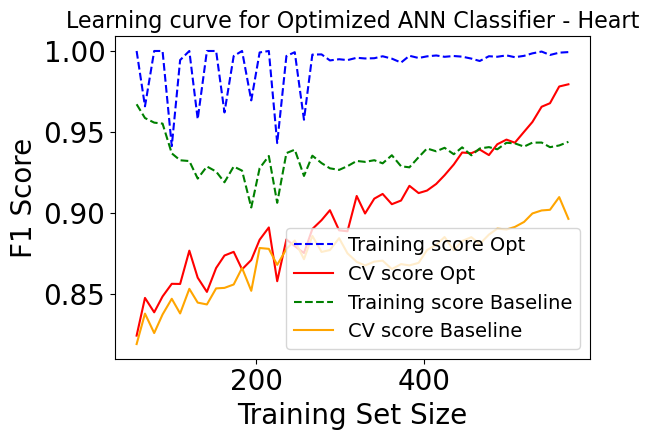

In [155]:
train_opt_ann_heart,val_opt_ann_heart,fit_opt_ann_heart,score_opt_ann_heart = plot_opt_vs_baseline_curves(ann_cv_opt_heart,X_train_heart,X_test_heart,y_train_heart,y_test_heart,5,train_ann_heart_base, val_ann_heart_base, 'Heart','ANN')

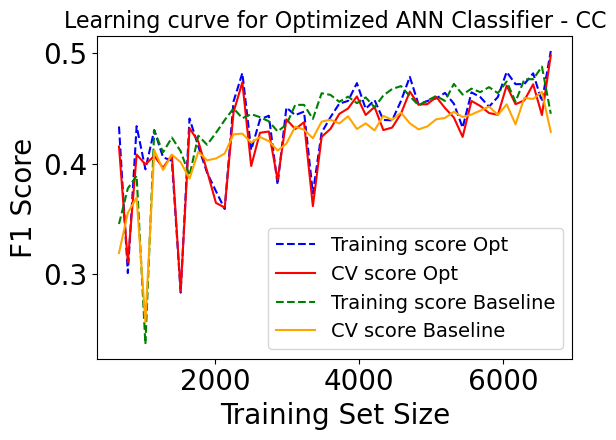

In [156]:
train_opt_ann_bank,val_opt_ann_bank,fit_opt_ann_bank,score_opt_ann_bank = plot_opt_vs_baseline_curves(ann_cv_opt_bank,X_train_bank,X_test_bank,y_train_bank,y_test_bank,3,train_ann_bank_base, val_ann_bank_base, 'CC','ANN')

Fitting Time: 2.1173343658447266
Scoring Time: 0.0019154548645019531
F1 Score - Heart Opt - ANN: 0.9904153354632589
              precision    recall  f1-score   support

          No       0.98      1.00      0.99       150
         Yes       1.00      0.98      0.99       158

    accuracy                           0.99       308
   macro avg       0.99      0.99      0.99       308
weighted avg       0.99      0.99      0.99       308



C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


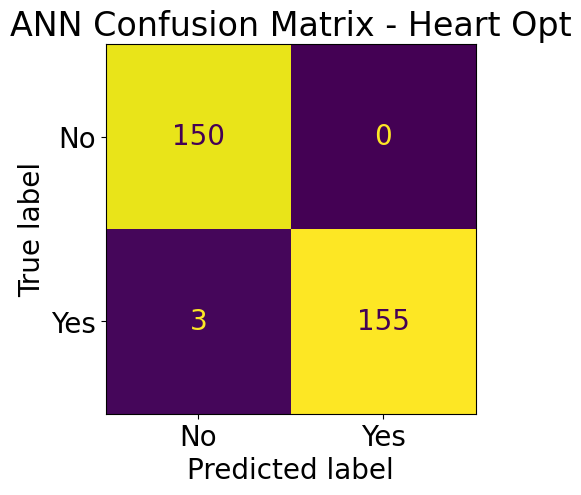

In [157]:
scoring_matrix(ann_cv_opt_heart.best_estimator_,X_train_heart,y_train_heart, X_test_heart, y_test_heart, 'Heart Opt', 'ANN')

C:\Users\UGGTech\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fitting Time: 30.356793880462646
Scoring Time: 0.1645493507385254
F1 Score - CC Opt - ANN: 0.49516332538903685
              precision    recall  f1-score   support

          No       0.85      0.94      0.89     15576
         Yes       0.65      0.40      0.50      4424

    accuracy                           0.82     20000
   macro avg       0.75      0.67      0.69     20000
weighted avg       0.80      0.82      0.80     20000



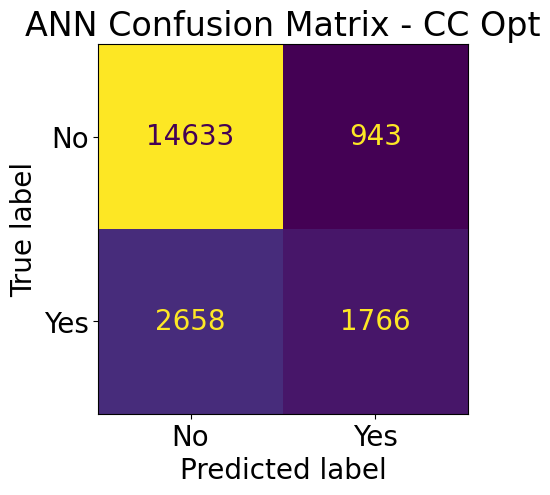

In [158]:
scoring_matrix(ann_cv_opt_bank.best_estimator_,X_train_bank,y_train_bank, X_test_bank, y_test_bank, 'CC Opt', 'ANN')

## Summary

In [184]:
# We want to plot all on the same graph
# Optimized scores vs sample size
# Times vs sample size

# Plot F1 Scores
def plot_f1(size,SVM_Opt_Score,KNN_Opt_Score,DT_Opt_Score, BT_Opt_Score, ANN_Opt_Score, name):
    plt.figure()
    plt.title("Optimized Model F1 Scores: " + name,fontsize = 16)
    plt.xlabel("Training Set Size")
    plt.ylabel("F1 Score")
    plt.plot(size, SVM_Opt_Score, color="r", label="SVM")
    plt.plot(size, KNN_Opt_Score, color="g", label="KNN")
    plt.plot(size, DT_Opt_Score, color="b", label="Decision Tree")
    plt.plot(size, BT_Opt_Score, color="m", label="Boosted Tree")
    plt.plot(size, ANN_Opt_Score, color="orange", label="ANN")
    plt.legend(loc="best",prop={'size': 14})
    plt.show()
    
def plot_fit_time(size,SVM_Opt_fit_time,KNN_Opt_fit_time,DT_Opt_fit_time, BT_Opt_fit_time, ANN_Opt_fit_time, name):
    plt.figure()
    plt.title("Fit Time: " + name,fontsize = 16)
    plt.xlabel("Training Set Size")
    plt.ylabel("Time [s]")
    plt.plot(size, SVM_Opt_fit_time, color="r", label="SVM")
    plt.plot(size, KNN_Opt_fit_time, color="g", label="KNN")
    plt.plot(size, DT_Opt_fit_time, color="b", label="Decision Tree")
    plt.plot(size, BT_Opt_fit_time, color="m", label="Boosted Tree")
    plt.plot(size, ANN_Opt_fit_time, color="orange", label="ANN")
    plt.legend(loc="best",prop={'size': 14})
    plt.show()
    
def plot_score_time(size,SVM_Opt_score_time,KNN_Opt_score_time,DT_Opt_score_time, BT_Opt_score_time, ANN_Opt_score_time, name):
    plt.figure()
    plt.title("Score Time: " + name,fontsize = 16)
    plt.xlabel("Training Set Size")
    plt.ylabel("Time [s]")
    plt.plot(size, SVM_Opt_score_time, color="r", label="SVM")
    plt.plot(size, KNN_Opt_score_time, color="g", label="KNN")
    plt.plot(size, DT_Opt_score_time, color="b", label="Decision Tree")
    plt.plot(size, BT_Opt_score_time, color="m", label="Boosted Tree")
    plt.plot(size, ANN_Opt_score_time, color="orange", label="ANN")
    plt.legend(loc="best",prop={'size': 14})
    plt.show()

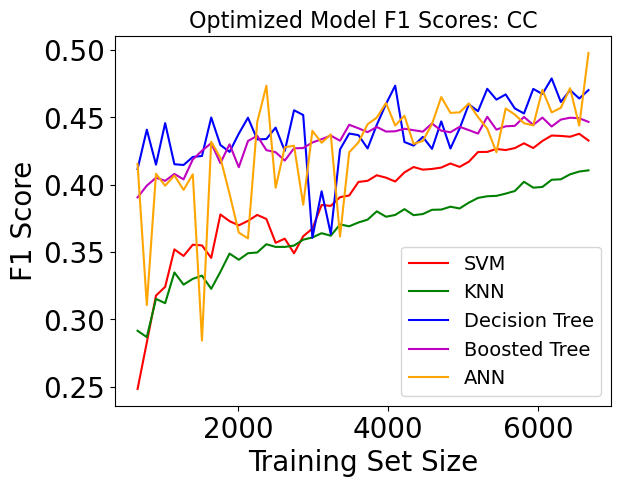

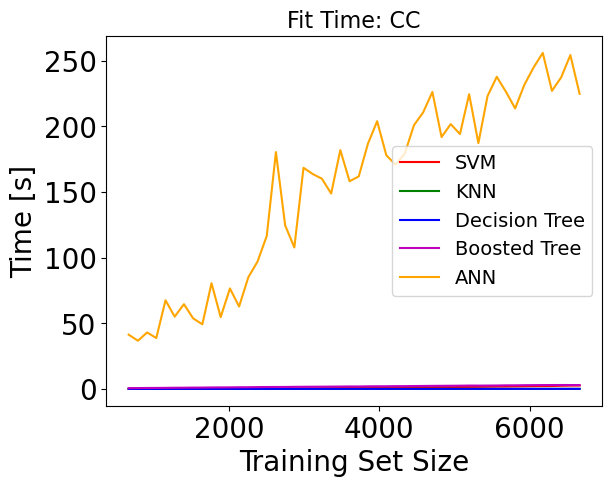

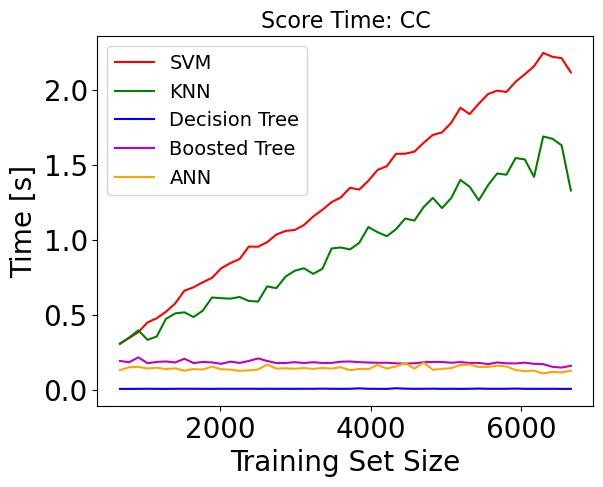

In [186]:
plot_f1(sizes_bank,val_opt_svc_bank,val_opt_knn_bank,val_opt_dt_bank, val_opt_bt_bank, val_opt_ann_bank, 'CC')

plot_fit_time(sizes_bank,fit_opt_svc_bank,fit_opt_knn_bank,fit_opt_dt_bank, fit_opt_bt_bank, fit_opt_ann_bank, 'CC')

plot_score_time(sizes_bank,score_opt_svc_bank,score_opt_knn_bank,score_opt_dt_bank, score_opt_bt_bank, score_opt_ann_bank, 'CC')

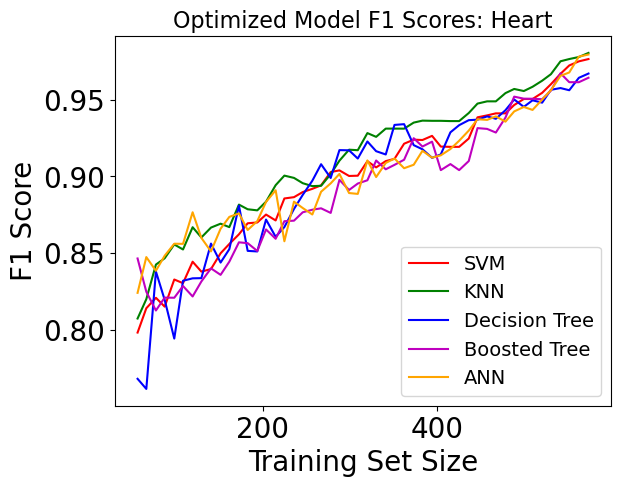

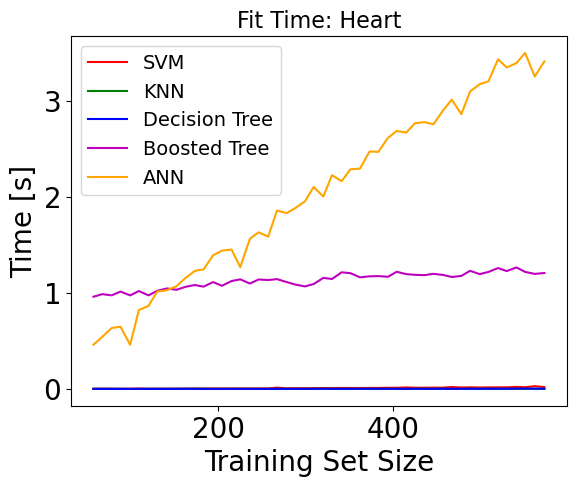

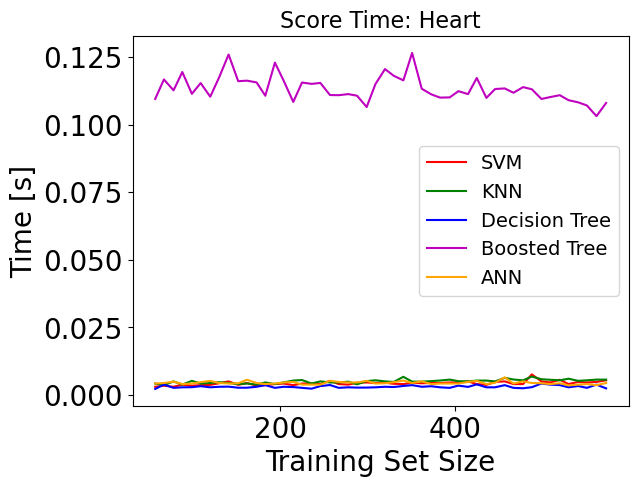

In [187]:
plot_f1(sizes_heart,val_opt_svc_heart,val_opt_knn_heart,val_opt_dt_heart, val_opt_bt_heart, val_opt_ann_heart, 'Heart')

plot_fit_time(sizes_heart,fit_opt_svc_heart,fit_opt_knn_heart,fit_opt_dt_heart, fit_opt_bt_heart, fit_opt_ann_heart, 'Heart')

plot_score_time(sizes_heart,score_opt_svc_heart,score_opt_knn_heart,score_opt_dt_heart, score_opt_bt_heart, score_opt_ann_heart, 'Heart')